# Прогнозирование поведения клиента (ДЗ)

Привет!

В последнем домашнем задании Интенсива тебе предстоит построить кривые def rate, внедрить ее в NPV-модель и зависимость обновленной модели от выбранного скора (подробные пункты перечислены ниже).  
Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score и PD (**data_scores.csv**). Не бойся выходить за рамки методов, предлженных в лекции.  
Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться работа:
За это ДЗ ты можешь получить максимум **10 баллов**. Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматься в случае неполного выполнения задания или отсутствия аргументации.


#### Задачи:

1) Построить кривые DEF rate (5 баллов)
    - Выбрать переменную для разбивки по бакетам (0.5 балла)
    - Провести анализ поколений (0.5 балла)
    - Построить винтажи DEF rate (0.5 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Провести анализ наличия внешних воздействий и при необходимости вычистить кривые (2 балла)
    - Построить среднее по винтажам для каждого бакета (0.5 балла)
    - Сгладить кривые (0.5 балла)
    
2) Внести в модель построенную кривую DEF rate и исследовать зависимость от скора (5 баллов)
    - Реализовать метод для расчета DEF rate по поданному скору (3 балла)
    - Рассчитать NPV для кредита с заданными параметрами (1 балл)
    - Построить кривую зависимости NPV от скора (1 балл)
    
**Пожалйуста, аргументируйте свои решения по каждому пункту**

В качестве результата по пунктам 2 и 3 приложи текущий ноутбук с названием 'Surname_def.ipynb'

#### Импорт библиотек

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # стиль для графиков
%matplotlib inline

from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

## Кривые DEF rate

#### Выгружаем данные с винтажами

In [9]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv

df_vintages = pd.read_csv("data_vintages.csv",
                          sep=";",
                          encoding="cp1251",
                          index_col=0,
                          parse_dates=["gen_month_dt", "gen_quarter_dt"],
                         )

In [10]:
df_vintages.head(10)

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
5,13089,14,2019-03-01,2019-01-01,0,0,0,1,0,0,0,1
6,132017,7,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
7,67966,24,2019-06-01,2019-04-01,1,0,0,0,1,0,0,0
8,152759,11,2019-11-01,2019-10-01,0,0,1,1,0,0,0,1
9,128462,20,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [12]:
# Тебе понадобятся два скора pd_score и x_score из файла data_scores.csv

df_scores = pd.read_csv("data_scores.csv", 
                        sep=";", 
                        encoding="cp1251", 
                        decimal=",", 
                        index_col=0
                       )

In [13]:
df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


#### Бьем выборку на бакеты и джойним с данными с винтажами

##### Мне кажется, что код с семинара с ошибкой

Менять не буду, просто отмечу, что были подозрения.

Код присваивает бакеты строкам после сортировки. При последующей сортировке pd_bucket остаётся привязанным к тем же user_id

In [16]:
# Разбей данные на 3 бакета по каждой переменной

# только сделаю в два отдельных df

df_scores = df_scores.sort_values(["pd"], ignore_index=True)
df_scores["pd_bucket"] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(["pd_bucket"])["pd"].mean())

df_scores = df_scores.sort_values(["x_score"], ignore_index=True)
df_scores["x_bucket"] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(["x_bucket"])["x_score"].mean())

df = df_vintages.merge(
    df_scores[["user_id", "pd_bucket", "x_bucket", "pd", "x_score"]],
    how="left",
    on="user_id",
).dropna()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


In [17]:
df.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,2,0.021296,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0,2,0,0.064742,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1,0,2,0.018490,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,1,0.025882,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0,1,1,0.024330,0.269492


### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом



In [19]:
df = df.copy()

# Вход в дефолт в месяце n
df["def_entry"] = ((df["def_flg"] == 1) & (df["prev_def_flg"] == 0)).astype(int)

# Активные в предыдущем месяце (n-1), т. е. наш знаменатель
df["act_prev"] = df["prev_act_flg"].astype(int)

In [20]:
def plot_def_rate_by_bucket(
    df,
    bucket_col,
    drop_gen_months=None,
    max_mob=24
):
    d = df.copy()
    if drop_gen_months:
        d = d[~d["gen_month_dt"].isin(pd.to_datetime(drop_gen_months))]

    d = d[d["statement_num"].between(1, max_mob)]

    agg = (
        d.groupby([bucket_col, "statement_num"])
         .agg(def_entry_cnt=("def_entry", "sum"),
              act_prev_cnt=("act_prev", "sum"))
         .assign(def_rate=lambda t: np.where(t["act_prev_cnt"] > 0,
                                            t["def_entry_cnt"] / t["act_prev_cnt"],
                                            np.nan))
         .sort_index()
    )

    ax = (agg["def_rate"]
          .unstack(bucket_col)
          .plot(figsize=(10, 6), grid=True, lw=3))

    return ax

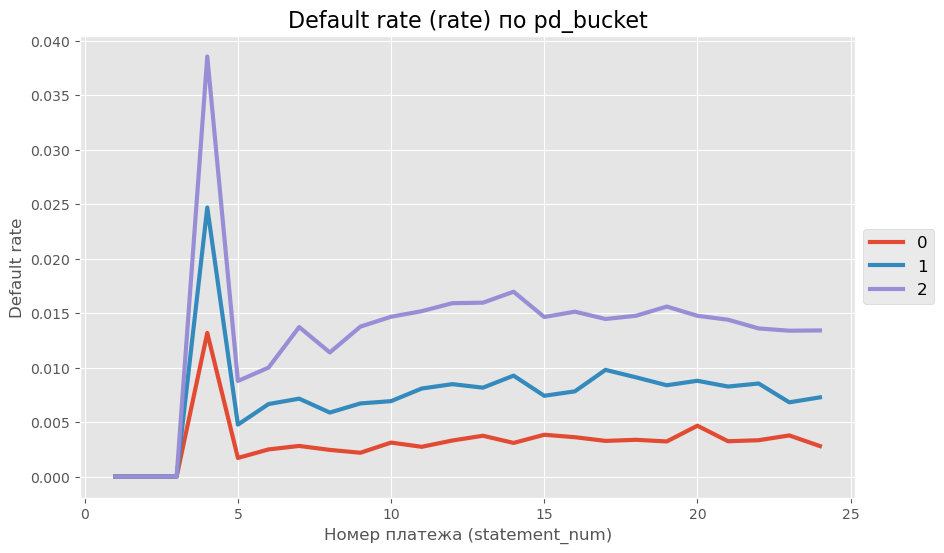

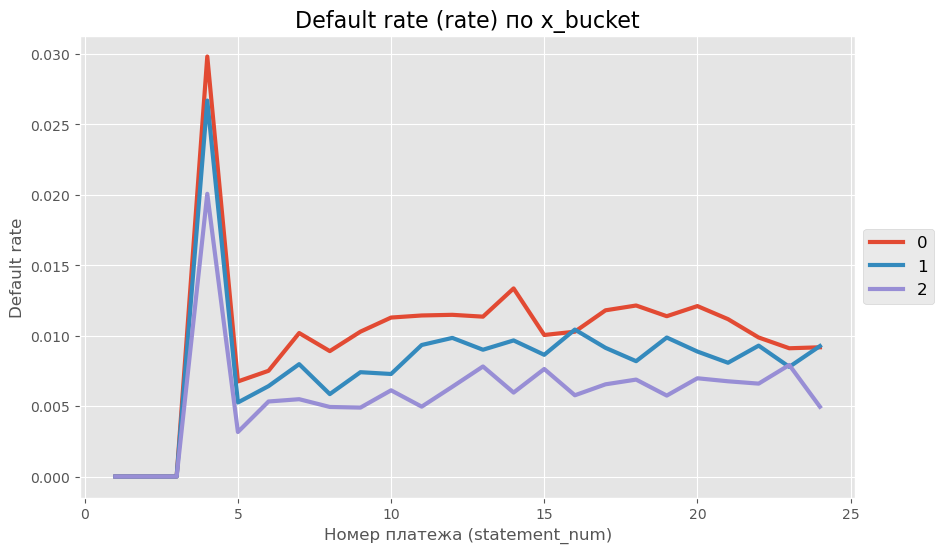

In [21]:
# по PD
plot_def_rate_by_bucket(df, "pd_bucket", drop_gen_months=["2019-04-01"])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title("Default rate (rate) по pd_bucket", size=16)
plt.xlabel("Номер платежа (statement_num)", size=12)
plt.ylabel("Default rate", size=12)
plt.show()

# по x_score
plot_def_rate_by_bucket(df, "x_bucket", drop_gen_months=["2019-04-01"])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title("Default rate (rate) по x_bucket", size=16)
plt.xlabel("Номер платежа (statement_num)", size=12)
plt.ylabel("Default rate", size=12)
plt.show()

#### Вывод: здесь укажи выбранную тобой переменную и обоснуй свой выбор

##### При использовании PD кривые лежат дальше друг от друга (расстояния между кривыми 0, 1, 2 визуально значительно больше), чем при использовании X_score, поэтому будем использовать именно разделение по переменной PD.

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

In [25]:
def plot_distribution(
    df,
    bucket_col="pd_bucket",
    time_col="gen_month_dt",
    max_gen_month=None,
    kind="count",
    figsize=(14, 6)
):
    d = df.copy()

    # фильтр по времени
    if max_gen_month is not None:
        d = d[d[time_col] < pd.to_datetime(max_gen_month)]

    # считаем уникальных клиентов в поколении
    counts = (
        d.groupby([time_col, bucket_col])["user_id"]
         .nunique()
         .unstack(bucket_col)
         .sort_index()
    )

    if kind == "share":
        plot_df = counts.div(counts.sum(axis=1), axis=0)
        ylabel = "Доля клиентов"
        title = f"Распределение клиентов по поколениям (доли), разрез: {bucket_col}"
    else:
        plot_df = counts
        ylabel = "Кол-во уникальных клиентов"
        title = f"Распределение клиентов по поколениям (объёмы), разрез: {bucket_col}"

    ax = plot_df.plot(figsize=figsize, grid=True, lw=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Поколение (gen_month_dt)", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=bucket_col, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    return ax

<Axes: title={'center': 'Распределение клиентов по поколениям (доли), разрез: pd_bucket'}, xlabel='Поколение (gen_month_dt)', ylabel='Доля клиентов'>

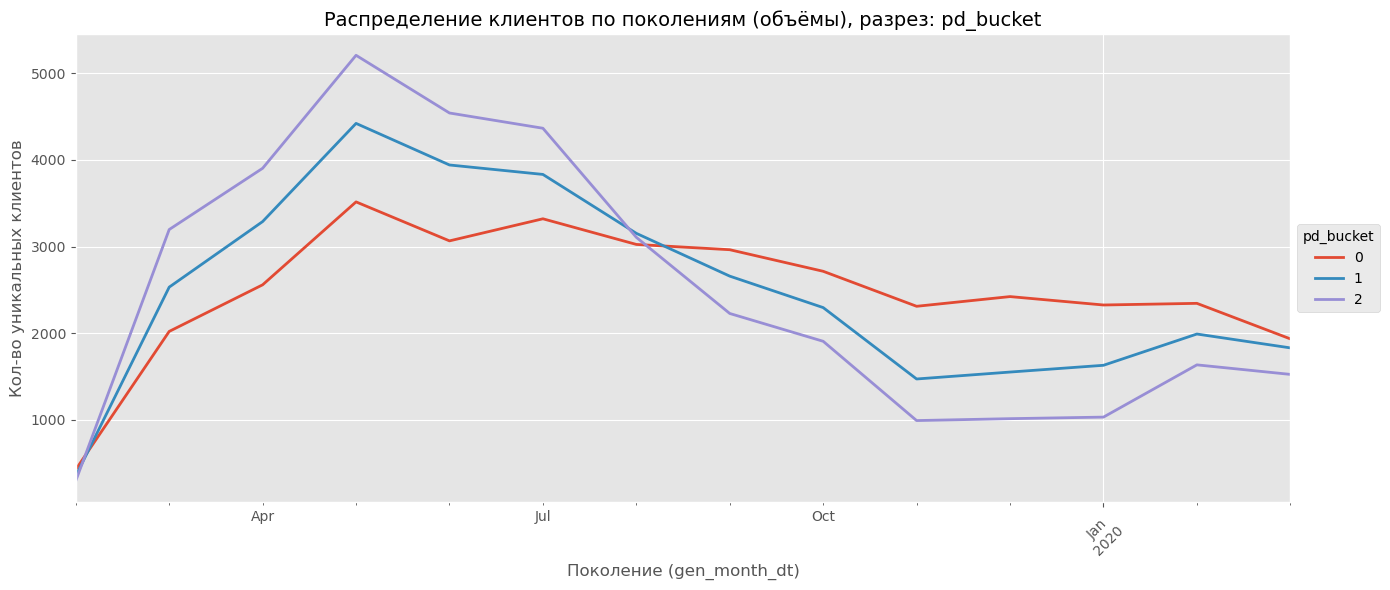

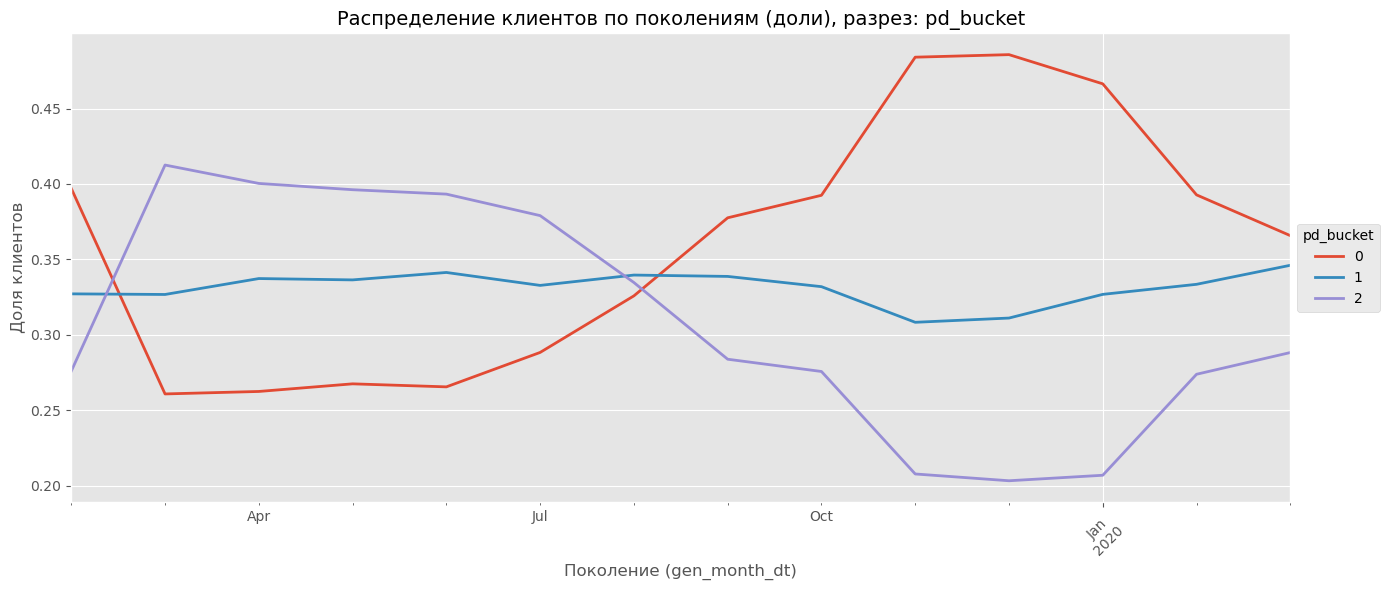

In [26]:
# Объёмы во времени по pd_bucket
plot_distribution(df, bucket_col="pd_bucket", kind="count")

# Доли бакетов во времени
plot_distribution(df, bucket_col="pd_bucket", kind="share")

#### Отдельно дам код для гистограммы с накоплением как в семинаре

<Axes: title={'center': 'Распределение по бакетам pd_bucket (доли)'}, xlabel='Поколение (gen_month_dt)', ylabel='Доля клиентов'>

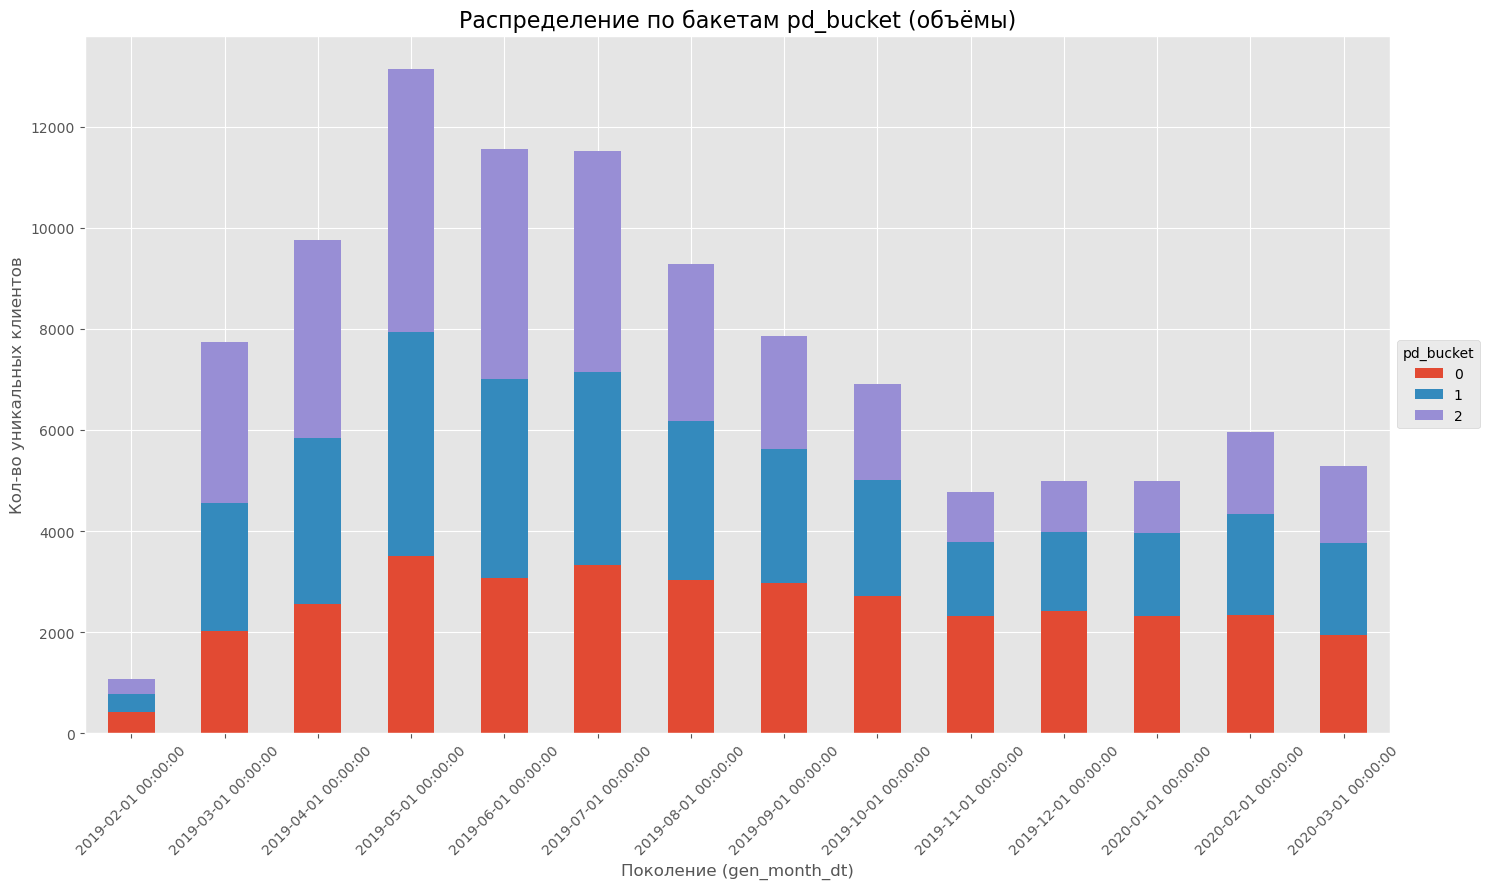

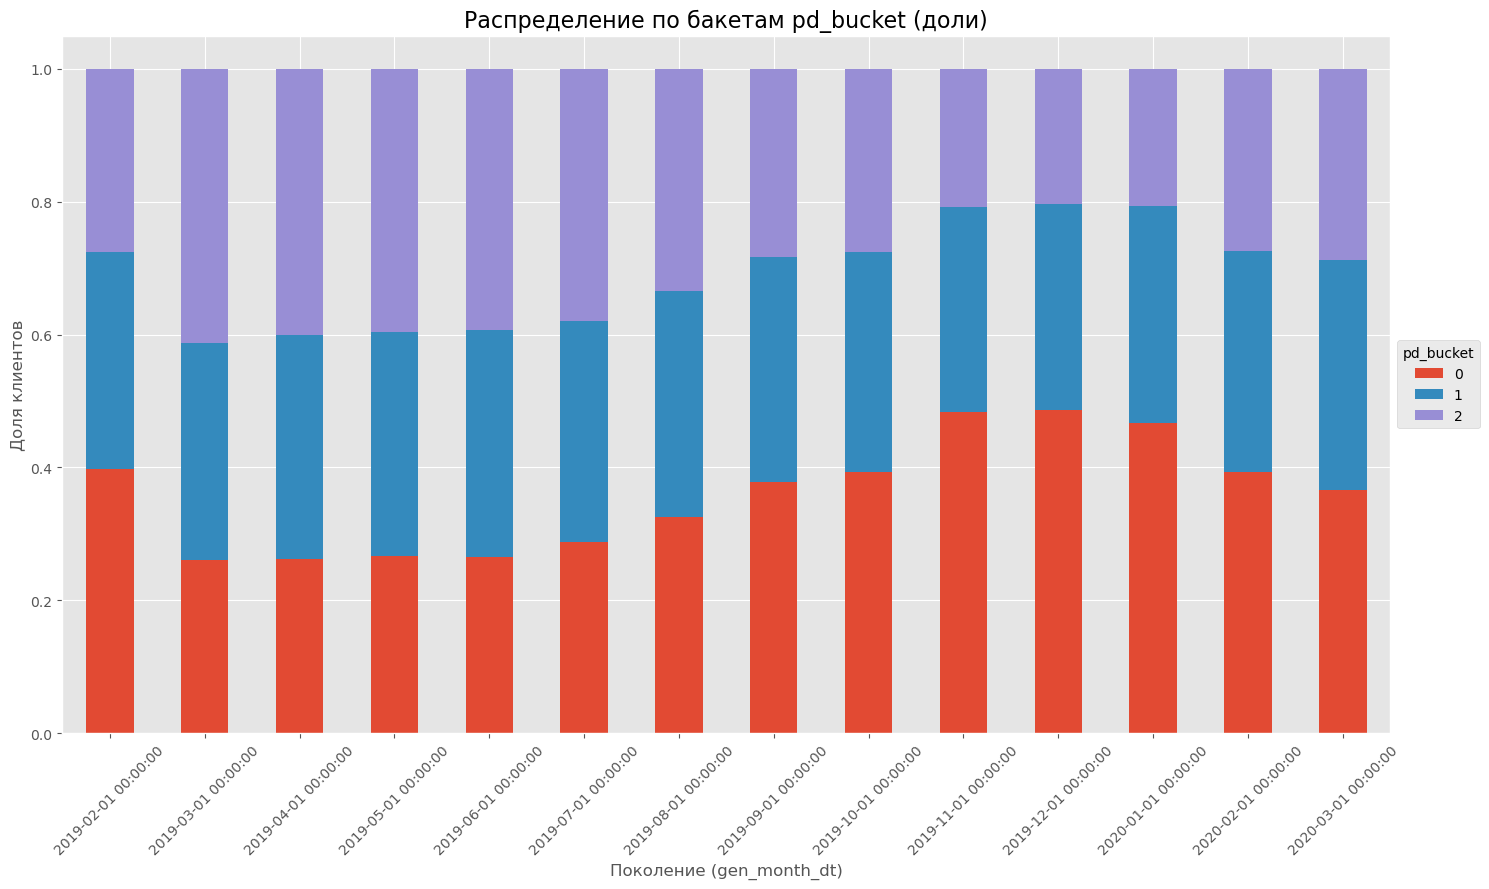

In [28]:
def plot_distribution_stacked_bar(df, bucket_col="pd_bucket", time_col="gen_month_dt",
                                  kind="count", figsize=(15, 9), max_gen_month=None):
    d = df.copy()

    if max_gen_month is not None:
        d = d[d[time_col] < pd.to_datetime(max_gen_month)]

    pt = (
        d.pivot_table(
            index=time_col,
            columns=bucket_col,
            values="user_id",
            aggfunc=pd.Series.nunique,
            fill_value=0
        )
        .sort_index()
    )

    if kind == "share":
        pt = pt.div(pt.sum(axis=1), axis=0)

    ax = pt.plot(kind="bar", stacked=True, figsize=figsize)
    ax.set_title(
        f"Распределение по бакетам {bucket_col} "
        + ("(доли)" if kind == "share" else "(объёмы)"),
        fontsize=16
    )
    ax.set_xlabel("Поколение (gen_month_dt)", fontsize=12)
    ax.set_ylabel("Доля клиентов" if kind == "share" else "Кол-во уникальных клиентов", fontsize=12)
    ax.tick_params(axis="x", rotation=45)
    plt.legend(title=bucket_col, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    return ax

# Объёмы
plot_distribution_stacked_bar(df, bucket_col="pd_bucket", kind="count")

# Доли
plot_distribution_stacked_bar(df, bucket_col="pd_bucket", kind="share")

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

##### Мне не нравится только поколение за февраль 2019 года, так как наблюдений слишком мало. Посмотрим внимательнее:

In [30]:
gen_feb = "2019-02-01"

bucket_counts = (
    df.loc[df["gen_month_dt"] == pd.to_datetime(gen_feb)]
      .groupby("pd_bucket")["user_id"]
      .nunique()
      .reindex([0, 1, 2])
)

display(bucket_counts)
print("Итого уникальных клиентов:", bucket_counts.sum())

pd_bucket
0    426
1    351
2    296
Name: user_id, dtype: int64

Итого уникальных клиентов: 1073


Удалим

In [32]:
df['gen_month_dt'].dtype

dtype('<M8[ns]')

In [33]:
df = df.loc[df["gen_month_dt"] != "2019-02-01"]

In [34]:
(df["gen_month_dt"] == pd.to_datetime("2019-02-01")).any()

False

### Кривые DEF Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи DEF rate в разбивке по бакетам

In [36]:
def plot_def_rate_by_generation(
    df,
    bucket_col="pd_bucket",
    bucket_value=0,
    max_gen_month=None,
    max_mob=24,
    figsize=(15, 9),
    lw=3
):
    d = df.copy()

    if "def_entry" not in d.columns:
        d["def_entry"] = ((d["def_flg"] == 1) & (d["prev_def_flg"] == 0)).astype(int)
    if "act_prev" not in d.columns:
        d["act_prev"] = d["prev_act_flg"].astype(int)

    if max_gen_month is not None:
        d = d[d["gen_month_dt"] < pd.to_datetime(max_gen_month)]

    d = d[d[bucket_col].notna()]
    d = d.query(f"{bucket_col} == @bucket_value")
    d = d[d["statement_num"].between(1, max_mob)]

    agg = (
        d.groupby(["gen_month_dt", "statement_num"])
         .agg(def_entry_cnt=("def_entry", "sum"),
              act_prev_cnt=("act_prev", "sum"))
         .assign(def_rate=lambda t: np.where(t["act_prev_cnt"] > 0,
                                            t["def_entry_cnt"] / t["act_prev_cnt"],
                                            np.nan))
    )

    ax = (agg["def_rate"]
          .unstack("gen_month_dt")
          .plot(figsize=figsize, grid=True, lw=lw))

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.title(f"Винтажи DEF rate (rate), {bucket_col} = {bucket_value}", size=16, verticalalignment="bottom")
    plt.xlabel("Номер платежа (statement_num)", size=12)
    plt.ylabel("Default entry rate", size=12)
    plt.tick_params(axis="both", which="major", labelsize=11)
    plt.tight_layout()

    return ax

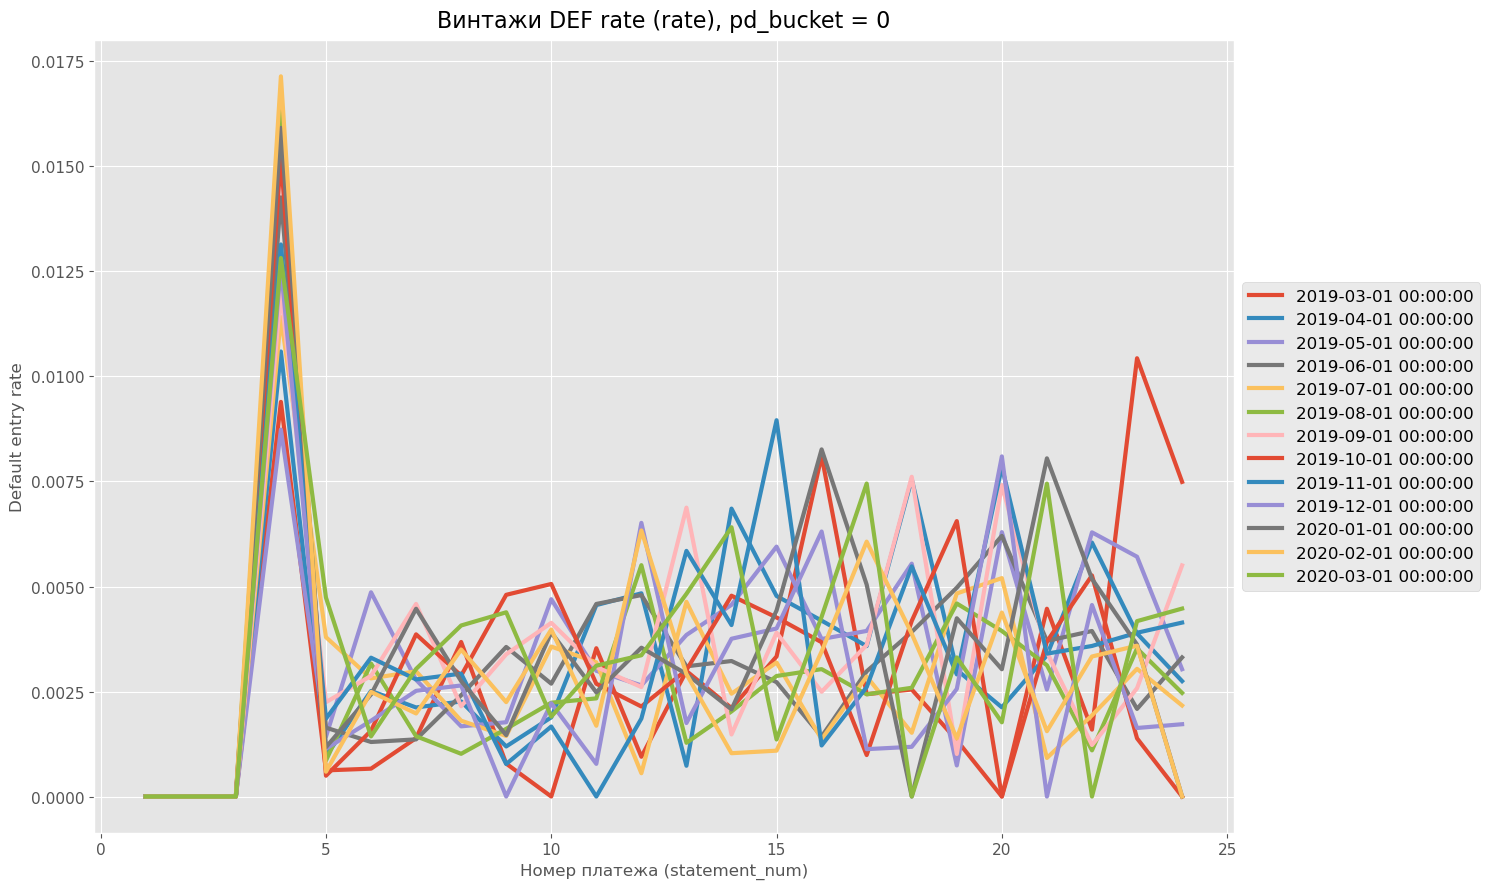

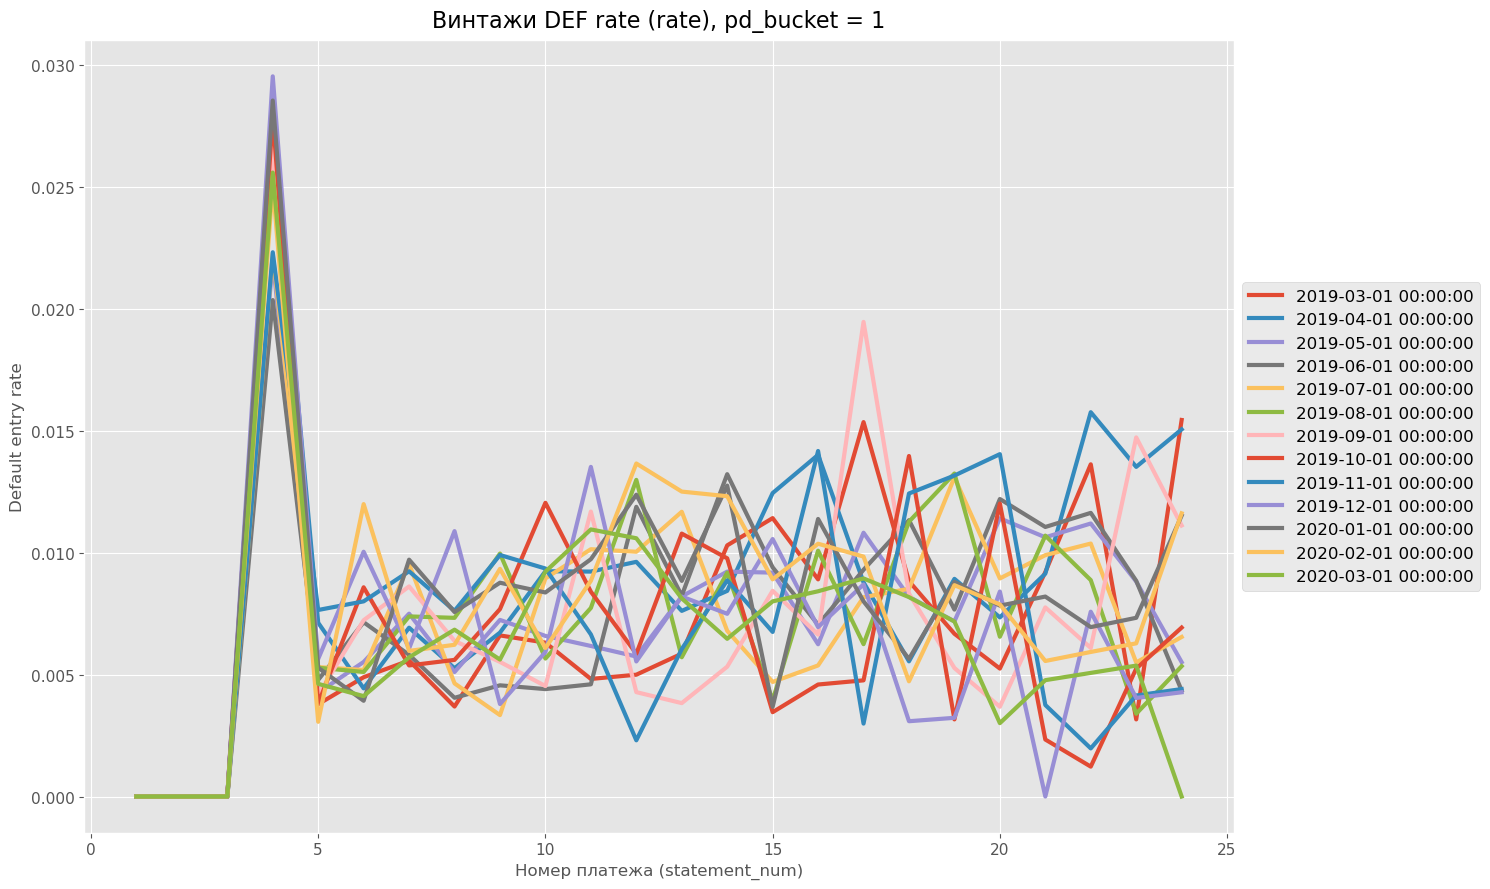

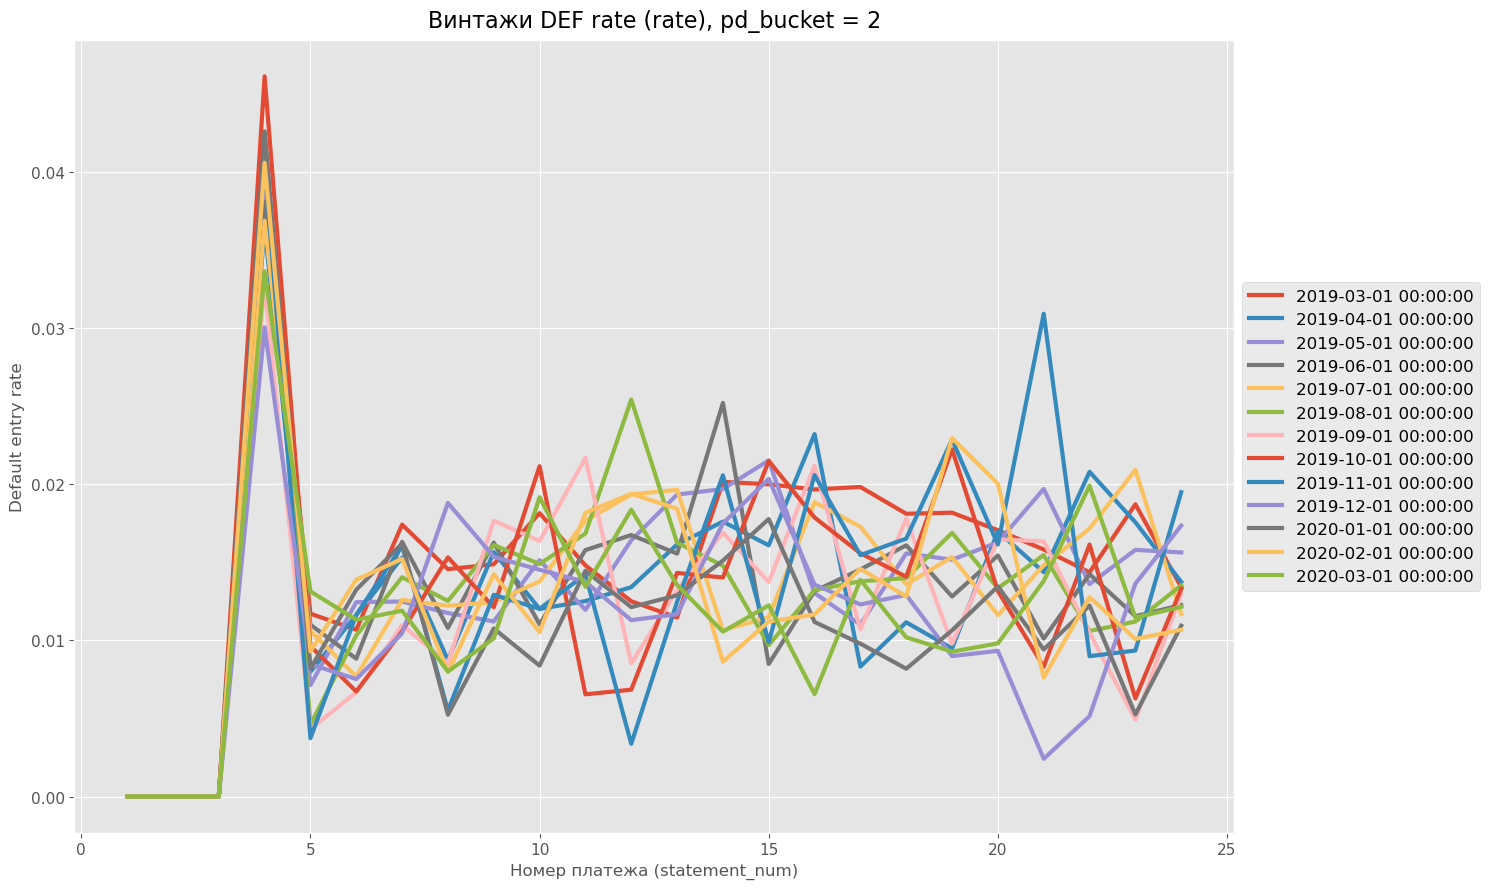

In [37]:
buckets = sorted(df["pd_bucket"].dropna().unique())
for b in buckets:
    plot_def_rate_by_generation(
        df,
        bucket_col="pd_bucket",
        bucket_value=b,
        max_mob=24
    )
    plt.show()

#### Выводы: сделай выводы по полученным графикам

##### Стандартно бакеты проранжированны по rate'ам, заметно про оси y. Касаемо шума и особых точек - ниже.

### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

Да, есть.

На всех графиках заметен резкий всплеск в районе платежа №4. 
Причина достаточно понятна. Еще на лекциях обсуждали, что это "фродовый пик". Но, помимо этого, это может быть интерпретирована как просрочка глубины 4, т. е. дефолт некоторого поколения клиентов.

Местами заметны выбросы. Хороший вопрос - что считать выбросом, а что нет. Для бакета 0 - кажется, что в районе +- 23 платежа есть выброс.
Для бакета 1 - платеж 17, поколение 2019-09-01. Возможно, 23-24 платежи тоже под вопросом.
Бакет 2 - платеж 21.

Мне кажется, что основную точку с номером платежа 4 убирать не стоит, все же это системная часть кривой. Думаю, ее и прочие шоки достаточно просто сгладить.

### Макроэкономические воздействие (2 балла)

#### Есть ли в винтажах DEF rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи DEF rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

---
#### Есть ли в винтажах DEF rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?

In [44]:
def build_calendar_defrate(df, bucket_col="pd_bucket", max_mob=24):
    d = df.copy()

    if "def_entry" not in d.columns:
        d["def_entry"] = ((d["def_flg"] == 1) & (d["prev_def_flg"] == 0)).astype(int)
    if "act_prev" not in d.columns:
        d["act_prev"] = d["prev_act_flg"].astype(int)

    d = d[d["statement_num"].between(1, max_mob)]
    d = d[d[bucket_col].notna()]

    d["obs_month"] = d["gen_month_dt"] + pd.to_timedelta((d["statement_num"] - 1) * 30, unit="D")
    d["obs_month"] = (d["gen_month_dt"].dt.to_period("M") + (d["statement_num"] - 1)).dt.to_timestamp()

    cal = (
        d.groupby([bucket_col, "obs_month"])
         .agg(def_entry_cnt=("def_entry", "sum"),
              act_prev_cnt=("act_prev", "sum"))
    )
    cal["def_rate"] = cal["def_entry_cnt"] / cal["act_prev_cnt"].replace(0, np.nan)
    return cal.reset_index()

cal = build_calendar_defrate(df, bucket_col="pd_bucket", max_mob=24)
cal.head()

,pd_bucket,obs_month,def_entry_cnt,act_prev_cnt,def_rate
0,0,2019-03-01,0,2020,0.000000
1,0,2019-04-01,0,4429,0.000000
2,0,2019-05-01,0,7691,0.000000
3,0,2019-06-01,16,10304,0.001553
4,0,2019-07-01,24,13036,0.001841


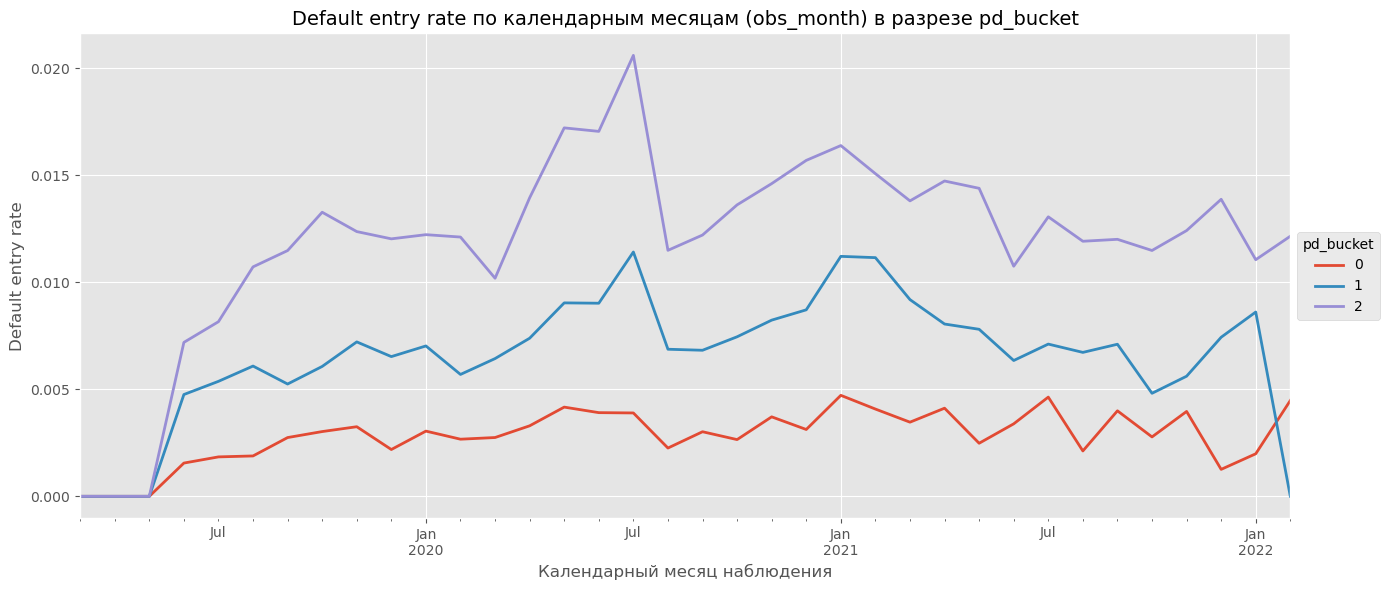

In [45]:
ax = (cal.pivot_table(index="obs_month", columns="pd_bucket", values="def_rate")
        .sort_index()
        .plot(figsize=(14,6), lw=2, grid=True))

ax.set_title("Default entry rate по календарным месяцам (obs_month) в разрезе pd_bucket", fontsize=14)
ax.set_xlabel("Календарный месяц наблюдения", fontsize=12)
ax.set_ylabel("Default entry rate", fontsize=12)
plt.legend(title="pd_bucket", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

#### Выводы: считаю, что макроэкономическое воздействие есть; примерно с февраля-марта (скорее, март, февраль "захватывается" лишь частично) 2020 по август 2020 (локдаун в связи с COVID-19). Также заметна часть, начиная с января-февраля 2022 (назовем это негативным новостым фоном до событий февраля 2022 и, собственно, сами события февраля 2022). Есть спорная часть в январе 2021 года, - не могу с уверенностью сказать, что здесь причиной является именно некоторое макроэкономическое событие.

##### Напомним идею разложения.

Сделаем обозначения:

$t$  - календарное время;

$n$  - номер поколения;

$(t−n)$  - месяц жизни клиента;


$D(t,n)$  - значения исследуемой кривой (DEF Rate) в месяц  $t$  для поколения номер  $n$ ;

$E(t)$  - внешние воздействия, которые зависят только от календарного времени  $t$ ;

$M(t−n)$  - кривая созревания, которая зависит только от месяца жизни клиента  $(t−n)$ .


Будем предполагать, что в идеальном случае существует разложение
$$D(n,t)=E(t)M(t−n)$$
 

Для поиска данного разложения будем минимизировать функционал
$$ F(E,M)=\sum_{n,t}{(D(t,n)−E(t)M(t−n))}^2 \to \min_{E,M} $$
 
где  $E={E(t),t>0}$, $M={M(t−n),t−n>0}$

In [48]:
def curve_build(data, feature, generation="generation_quart",
                statement_num="statement_num", group_label="1", stable_from=6):

    df_query = data.sort_values([generation, statement_num]).reset_index(drop=True)

    generation_min = df_query[generation].min()

    values = df_query[feature].to_numpy(dtype=float)
    st_nums = (df_query[statement_num].to_numpy(dtype=int) - 1)   # возраст a=0..A-1

    # календарный индекс t=0..T-1 для каждой строки
    dates = (
        df_query[generation].dt.year * 12 + df_query[generation].dt.month
        - (generation_min.year * 12 + generation_min.month)
        + df_query[statement_num].to_numpy(dtype=int) - 1
    ).to_numpy(dtype=int)

    A = int(st_nums.max() + 1)          # длина M(a)
    T = int(dates.max() + 1)            # длина E(t)
    tab_size = len(df_query)

    stable_mask = (np.arange(T) >= stable_from)  # t>=6

    def unpack_x(x):
        E_raw = x[:T]
        M_raw = x[T:T+A]

        # среднее только по "стабильному" окну
        if stable_mask.any():
            mean_E = E_raw[stable_mask].mean()
        else:
            mean_E = E_raw.mean()

        if mean_E == 0:
            mean_E = 1e-12

        # теперь mean(E[stable_mask]) == 1
        E = E_raw / mean_E

        # сохраняем инвариантность произведения E*M
        M = M_raw * mean_E
        return E, M

    def r_square(x):
        E, M = unpack_x(x)
        pred = E[dates] * M[st_nums]
        return np.sum((values - pred) ** 2)

    x0 = np.ones(T + A, dtype=float)

    res0 = minimize(
        r_square,
        x0,
        tol=1e-6,
        method="Powell",
        options={"disp": False, "maxiter": 1000},
    )

    # достаем уже нормированные E и M
    E_hat, M_hat = unpack_x(res0.x)

    external_data = pd.DataFrame({
        "month_dt": [generation_min + pd.DateOffset(months=i) for i in range(T)],
        group_label: E_hat
    })

    maturation_data = pd.DataFrame({
        "statement_num": np.arange(1, A + 1),
        group_label: M_hat
    })

    # fitted: D / E (если хотите "очистить" от макро)
    df_query = df_query.copy()
    df_query["month_dt"] = pd.to_datetime(df_query["month_dt"], errors="coerce")
    external_data["month_dt"] = pd.to_datetime(external_data["month_dt"], errors="coerce")

    df_fitted = df_query.merge(external_data, on="month_dt", how="left")
    df_fitted["fitted_feature"] = df_fitted[feature] / df_fitted[group_label]

    return {
        "res0": res0,
        "external_data": external_data,
        "maturation_data": maturation_data,
        "df_fitted": df_fitted,
    }

def decomposition(
    df,
    generation="generation_month",
    group="bucket",
    statement_num="statement_num",
    feature="feature",
    optimization_query="",
):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == "":
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))
    df_query["month_dt"] = df_query[generation] + timedelta

    # Формируем список бакетов

    df_query.sort_values(by=[group], inplace=True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + " = " + str(g))

        # Строим разложение для одного бакета
        res = curve_build(
            df_temp,
            feature=feature,
            generation=generation,
            statement_num=statement_num,
            group_label=str(g),
        )
        df_fitted_temp = pd.DataFrame(res["df_fitted"])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res["external_data"])[["month_dt", str(g)]]
            maturation_data = pd.DataFrame(res["maturation_data"])[
                [statement_num, str(g)]
            ]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(
                right=res["external_data"], on=["month_dt"]
            )
            maturation_data = maturation_data.merge(
                right=res["maturation_data"], on=[statement_num]
            )
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i += 1

    # print(res)

    res_multiple = {
        "external_data": external_data,
        "maturation_data": maturation_data,
        "fitted_data": df_fitted,
    }
    return res_multiple

In [49]:
df

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score,def_entry,act_prev
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,2,0.021296,0.469410,0,1
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0,2,0,0.064742,0.157215,0,0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1,0,2,0.018490,0.469583,0,1
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,1,0.025882,0.210896,0,1
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0,1,1,0.024330,0.269492,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493263,64006,19,2019-05-01,2019-04-01,1,0,0,0,0,0,1,1,2,1,0.052035,0.188233,0,1
2493264,138666,21,2019-09-01,2019-07-01,1,0,0,0,0,0,0,1,0,1,0.012906,0.221981,0,1
2493265,120568,1,2019-08-01,2019-07-01,0,0,0,1,0,0,0,1,2,0,0.059505,0.104274,0,1
2493266,191861,6,2020-01-01,2020-01-01,0,0,0,1,0,0,0,1,0,0,0.007966,0.172479,0,1


In [50]:
df_def_rate = (
    df.groupby(["pd_bucket", "gen_month_dt", "statement_num"], as_index=False)
    .agg(def_entry_cnt=("def_entry", "sum"),
    act_prev_cnt=("act_prev", "sum"))
)

df_def_rate["def_rate"] = df_def_rate["def_entry_cnt"] / df_def_rate["act_prev_cnt"].replace(0, np.nan)


res = decomposition(
    df_def_rate.dropna(subset=["def_rate"]),
    generation="gen_month_dt",
    group="pd_bucket",
    statement_num="statement_num",
    feature="def_rate",
)

C:\Users\smirn\AppData\Local\Temp\ipykernel_34672\2580818573.py:122: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query["month_dt"] = df_query[generation] + timedelta


pd_bucket = 0
pd_bucket = 1
pd_bucket = 2


In [51]:
# Проверяем, что действительно нормировали внешку
stable_from = 6

E = res['external_data'][['0', '1', '2']].to_numpy()
t = np.arange(len(E))
mask = t >= stable_from

mean_stable = E[mask].mean()

print("Mean(E):", mean_stable)

Mean(E): 1.0


#### Получившиеся кривые внешних воздействий

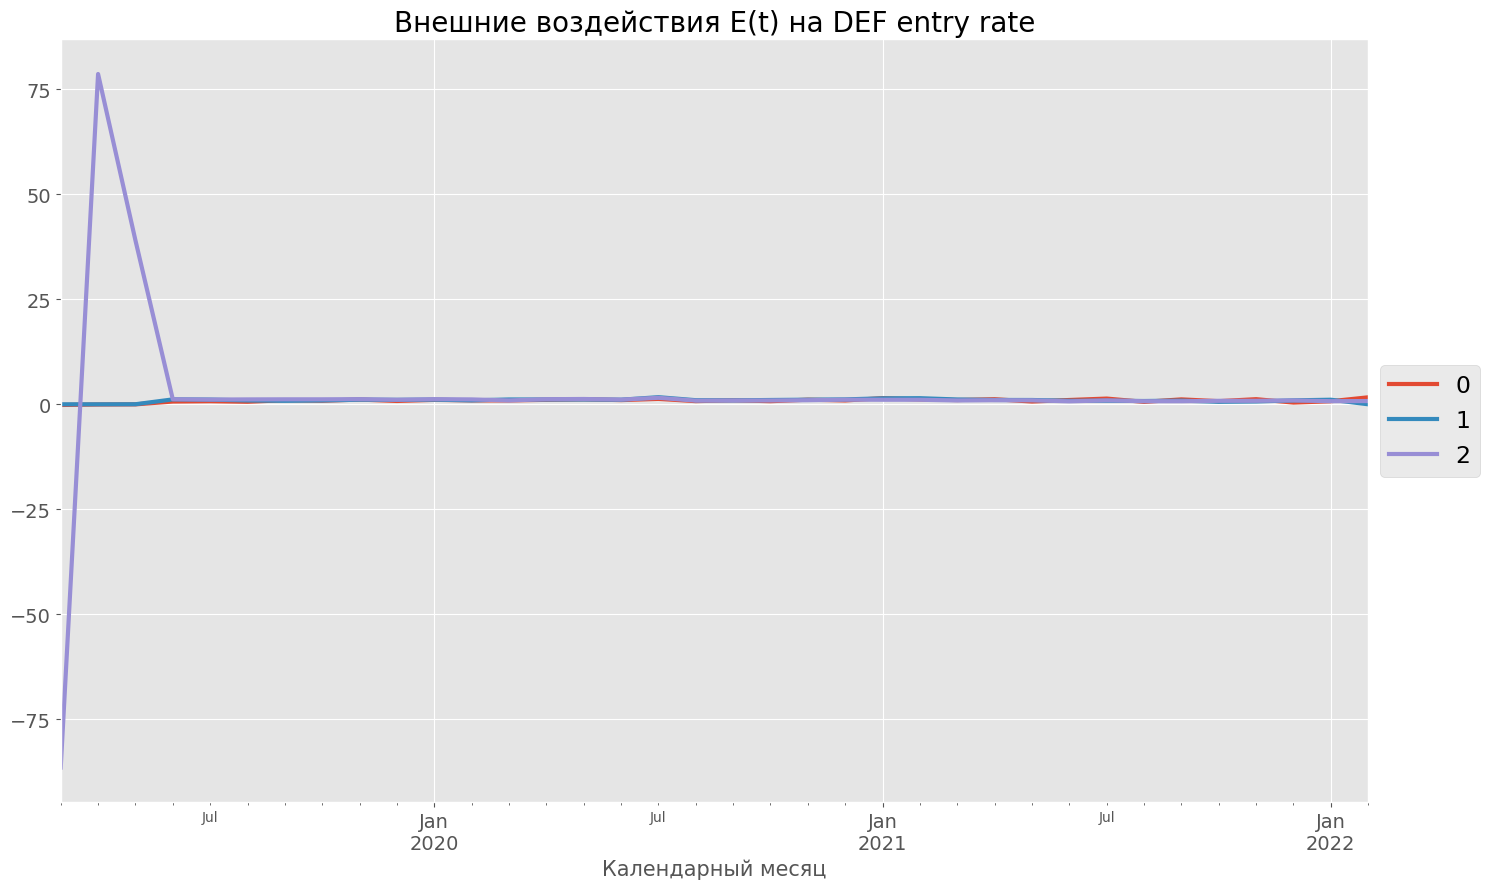

In [53]:
(res["external_data"]
 .set_index("month_dt")[["0","1","2"]]
 .plot(figsize=(15, 9), grid=True, lw=3))

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17)
plt.title("Внешние воздействия E(t) на DEF entry rate", size=20)
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

#### Кривые DefRate ratio, вычищенные от внешних воздействий

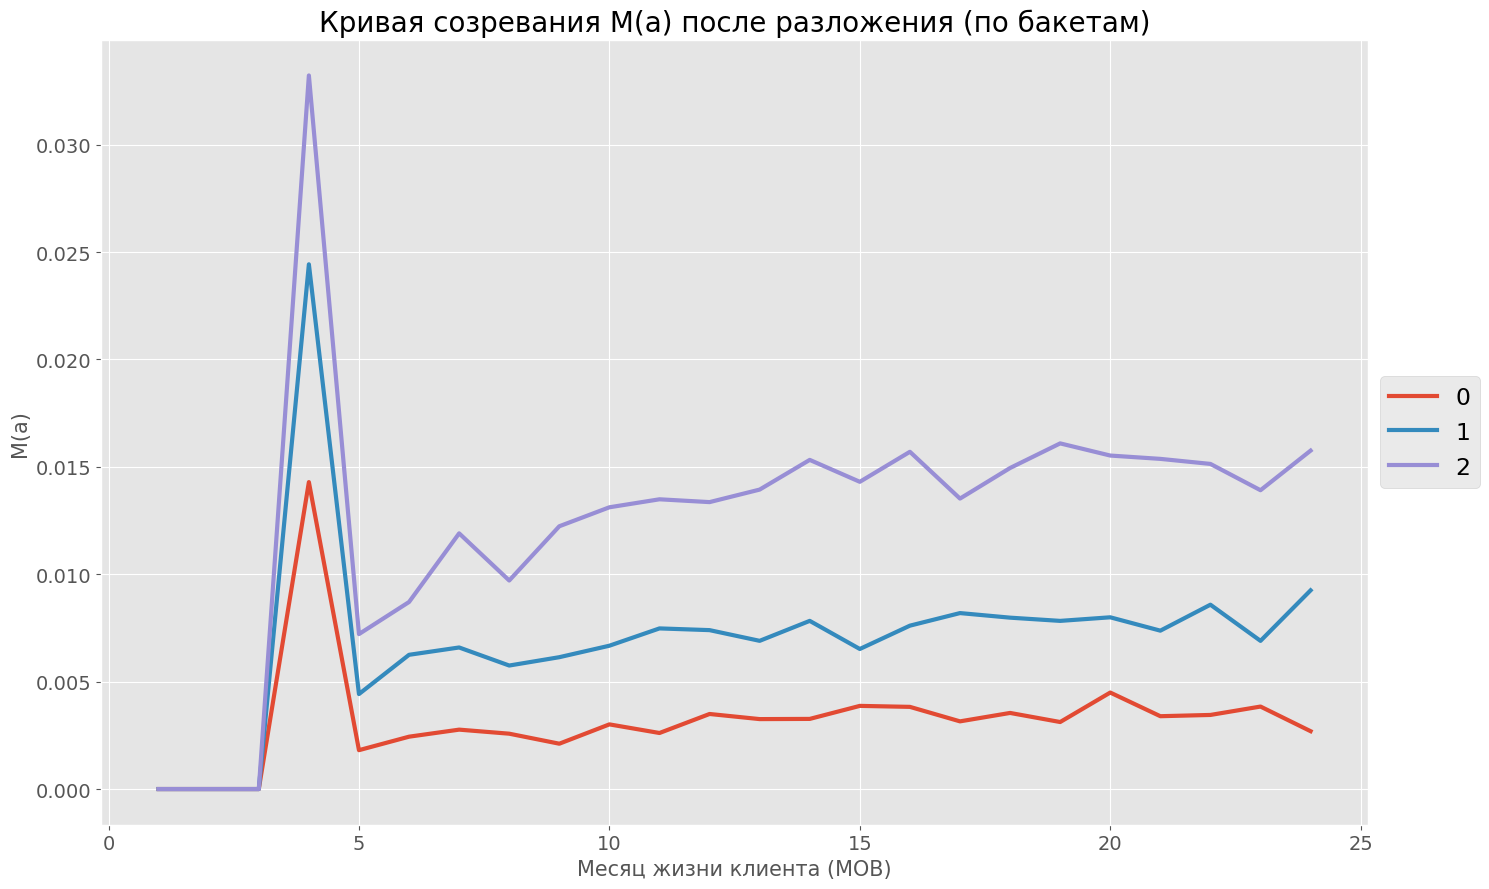

In [55]:
ax = (res["maturation_data"]
      .set_index("statement_num")[["0","1","2"]]
      .plot(figsize=(15, 9), grid=True, lw=3))

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17)
plt.title("Кривая созревания M(a) после разложения (по бакетам)", size=20)
plt.xlabel("Месяц жизни клиента (MOB)", size=15)
plt.ylabel("M(a)", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

#### Вывод:

На графике E(t) видно, что внешние шоки почти везде близки к нулю, кроме сильного единичного всплеска в самом начале (особенно для бакета 2) - дальше влияние внешней среды на DEF entry rate выглядит слабым и стабильным.

На графике M(a) видно, что различия между бакетами в дефолтности устойчивые; бакет 2 системно самый рискованный, бакет 0 - самый приемлемый, при этом у всех есть ранний пик (примерно MOB 4), после которого кривые выходят на более ровный уровень.

### Среднее по бакетам (0.5 баллов) 
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

In [57]:
# Реализация расчета среднего

#     код здесь

curve_mean = (
    res["fitted_data"]
    .groupby(["pd_bucket", "statement_num"])["fitted_feature"]
    .mean()
    .rename("Среднее")
)



# Построй графики винтажей и среднего

def plot_def_rate_mean(pd_bucket, max_mob=24):
    d = res["fitted_data"].query(
        "pd_bucket == @pd_bucket and statement_num >= 1 and statement_num <= @max_mob"
    ).copy()

    ax = (
        d.pivot_table(
            index="statement_num",
            columns="gen_month_dt",
            values="fitted_feature",
            aggfunc="mean",
        )
        .sort_index()
        .plot(figsize=(15, 9), grid=True, lw=2, alpha=0.6)
    )

    m = curve_mean.loc[pd_bucket].sort_index()
    m = m[(m.index >= 1) & (m.index <= max_mob)]
    m.plot(ax=ax, lw=3, color="black", ls="--", label="Среднее")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.title(f"Вычищенные винтажи и средняя: pd_bucket={pd_bucket}", size=18)
    plt.xlabel("Месяц жизни клиента (MOB)", size=14)
    plt.ylabel("DEF entry rate (очищенный)", size=14)
    plt.tight_layout()
    plt.show()


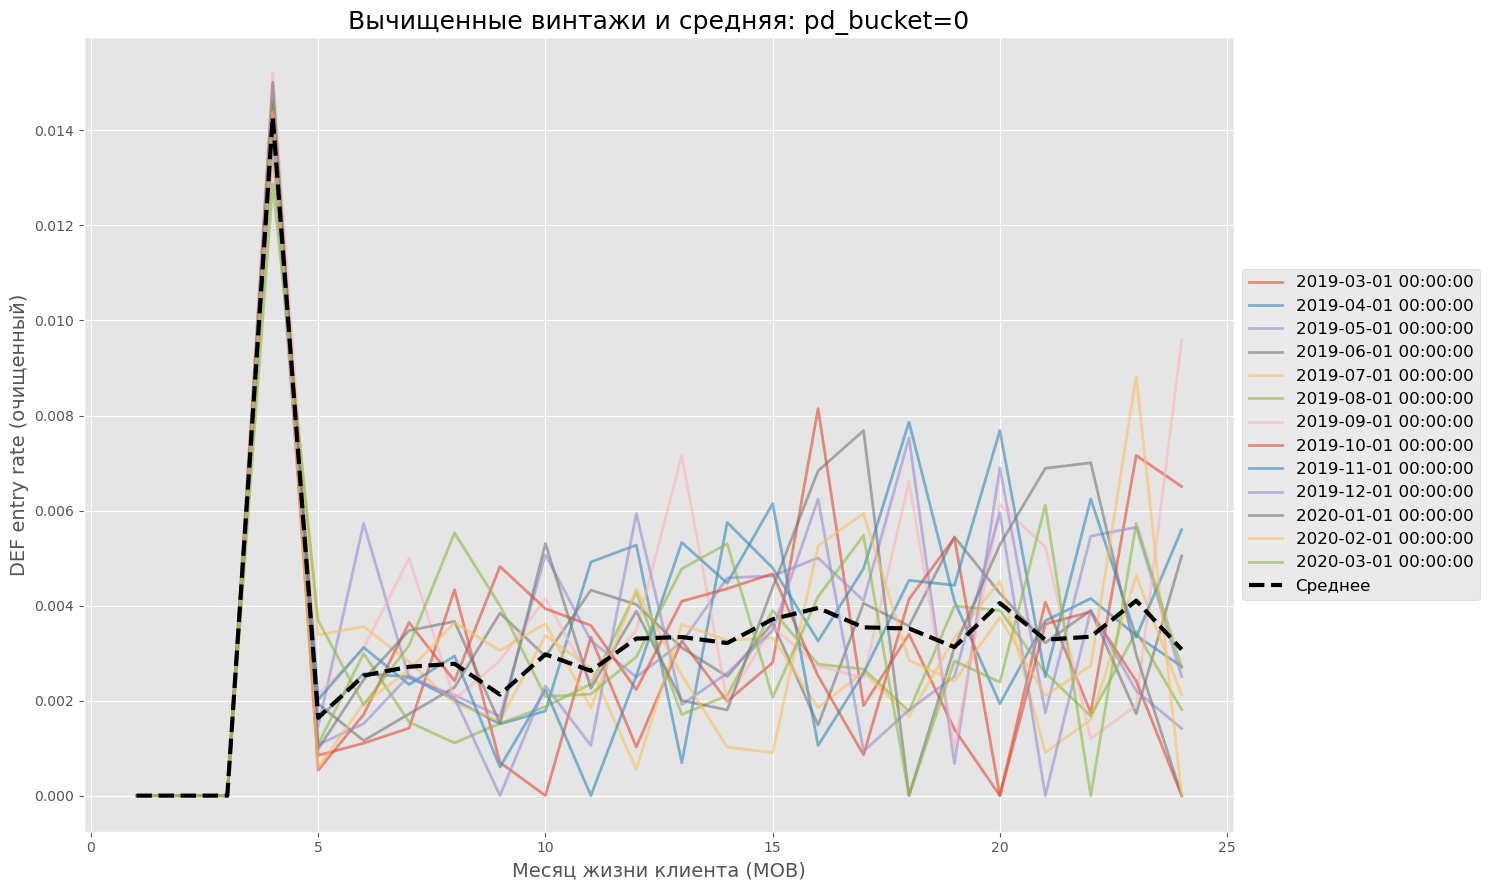

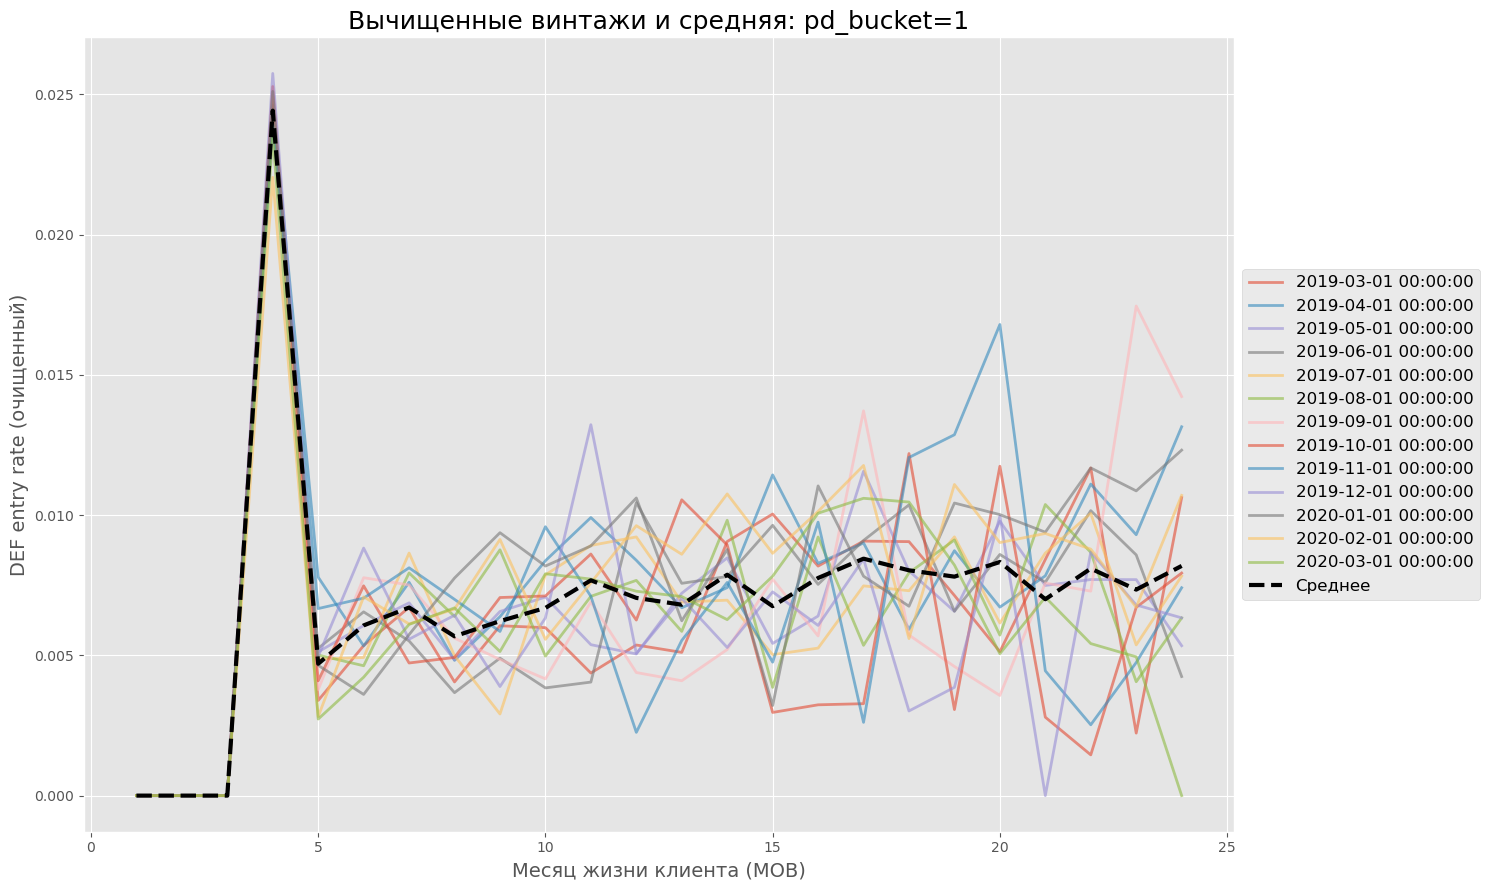

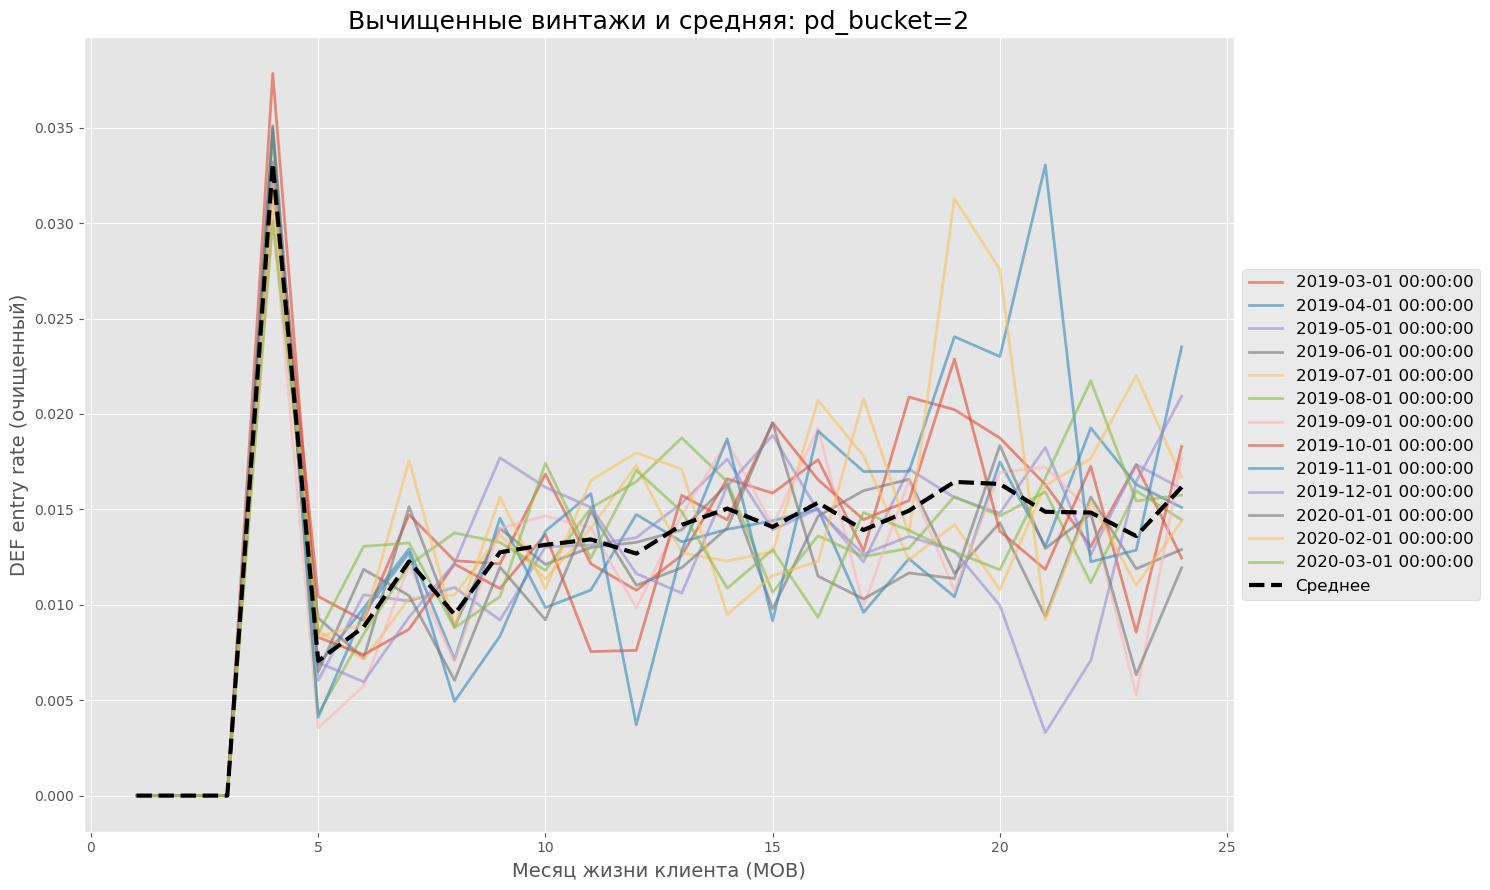

In [58]:
for b in sorted(res["fitted_data"]["pd_bucket"].dropna().unique()):
    plot_def_rate_mean(b, max_mob=24)


### Сглаживание средних кривых (0.5 баллов) 

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

### Найдем лучшую функцию для сглаживания кривых

In [61]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res["Линейная функция"] = df["Среднее"]  # Копируем средние значения
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], 1
    )  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)  # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, "Линейная функция"] = linear_coeff(
        np.arange(start, finish + 1)
    )  # Записываем приближение
    df_res.loc[finish + 1 :, "Линейная функция"] = linear_coeff(
        finish + 1
    )  # Продолжаем кривую константой
    return df_res


def polynom_approximation(df, start=1, finish=20, degree=1):
    df_res = pd.DataFrame(df)
    df_res["Полином"] = df["Среднее"]
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], degree
    )  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, "Полином"] = linear_coeff(np.arange(start, finish + 1))
    df_res.loc[finish + 1 :, "Полином"] = linear_coeff(finish + 1)
    return df_res

# чуть-чуть поменял
def exponential_smoothing(df, alpha=0.25, col="Среднее"):
    df_res = pd.DataFrame(df).copy()
    df_res = df_res.sort_index()

    y = df_res[col].to_numpy(dtype=float)
    s = np.empty_like(y)

    s[0] = y[0]  # старт с первого значения
    for i in range(1, len(y)):
        s[i] = alpha * y[i] + (1 - alpha) * s[i - 1]

    df_res["Скользящее среднее"] = s
    return df_res

In [62]:
mean_df = curve_mean.reset_index()

b = 2
df_linear = (
    mean_df.query("pd_bucket == @b")
           .set_index("statement_num")
           .sort_index()
)

df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4, 24, 2)
df_smooth = exponential_smoothing(df_polynom, alpha=0.25, col="Среднее")

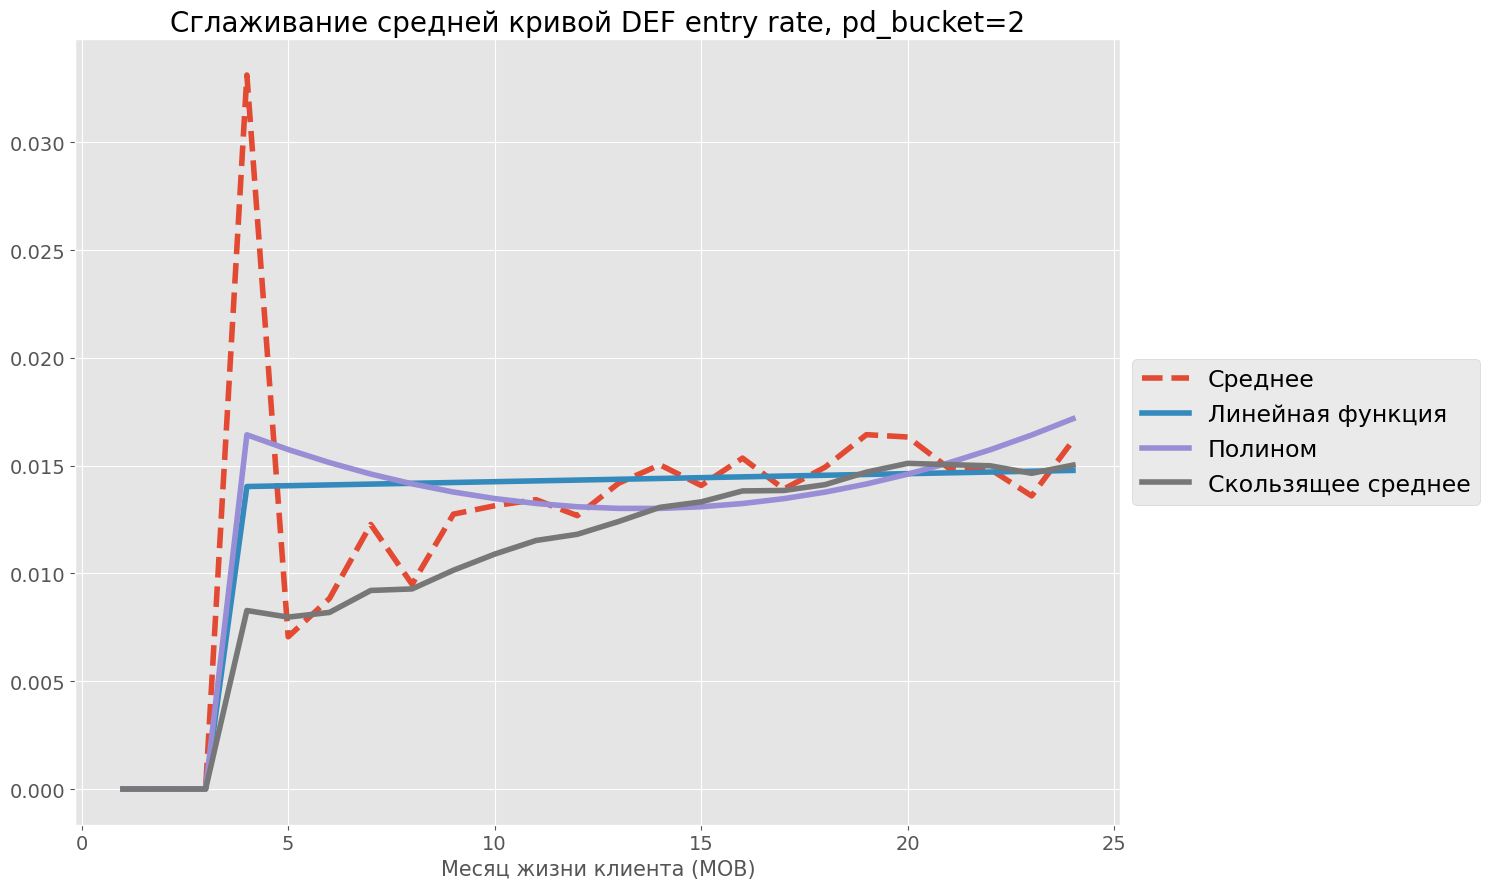

In [63]:
plt.figure(figsize=(15, 9))
df_smooth["Среднее"].plot(grid=True, linestyle="--", lw=4)
df_smooth["Линейная функция"].plot(grid=True, linestyle="-", lw=4)
df_smooth["Полином"].plot(grid=True, linestyle="-", lw=4)
df_smooth["Скользящее среднее"].plot(grid=True, linestyle="-", lw=4)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17)
plt.title(f"Сглаживание средней кривой DEF entry rate, pd_bucket={b}", size=20)
plt.xlabel("Месяц жизни клиента (MOB)", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

#### Для приближения воспользуемся полиномом, - считаю, что он дает наиболее удачную аппроксимацию (MA-сглаживание не совсем удачно, линейная функция, очевидно, совсем плохо покрывает среднее из-за невозможности учесть флуктуации линии среднего)

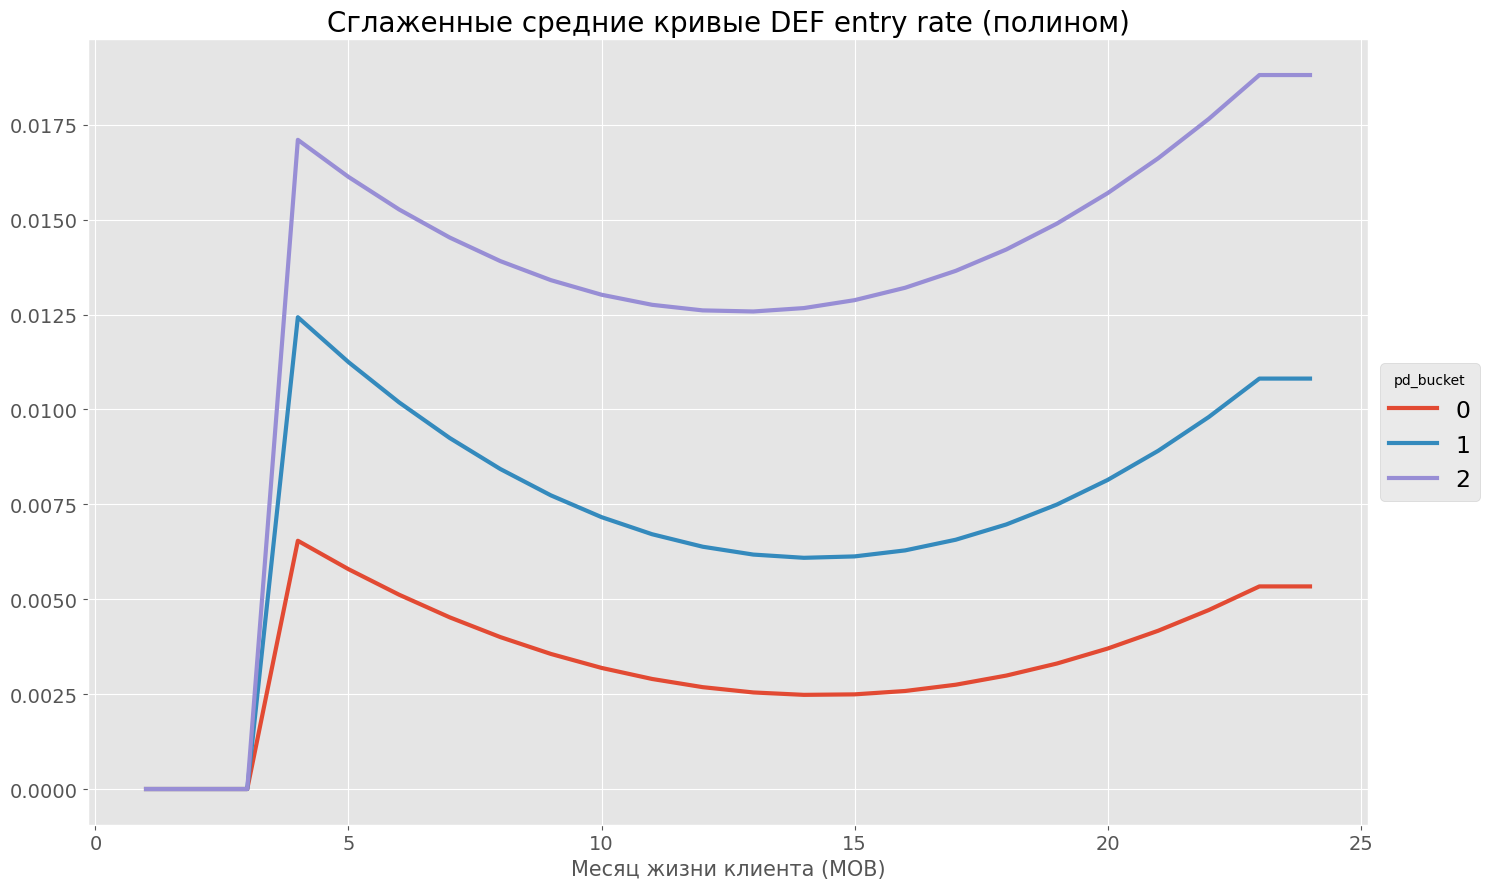

In [65]:
buckets = sorted(res["fitted_data"]["pd_bucket"].dropna().unique())

curve_mean = (
    res["fitted_data"]
    .groupby(["pd_bucket", "statement_num"])["fitted_feature"]
    .mean()
    .rename("Среднее")
)

mean_df = curve_mean.reset_index()

df_smooth_result = pd.DataFrame()

for bucket in buckets:
    df_temp = (
        mean_df.query("pd_bucket == @bucket")
               .set_index("statement_num")
               .sort_index()
    )
    df_smooth_result[str(bucket)] = polynom_approximation(
        df_temp, start=4, finish=22, degree=2
    )["Полином"]


df_smooth_result.plot(figsize=(15, 9), grid=True, lw=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17, title="pd_bucket")
plt.title("Сглаженные средние кривые DEF entry rate (полином)", size=20)
plt.xlabel("Месяц жизни клиента (MOB)", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

##### Вставим сюда всё

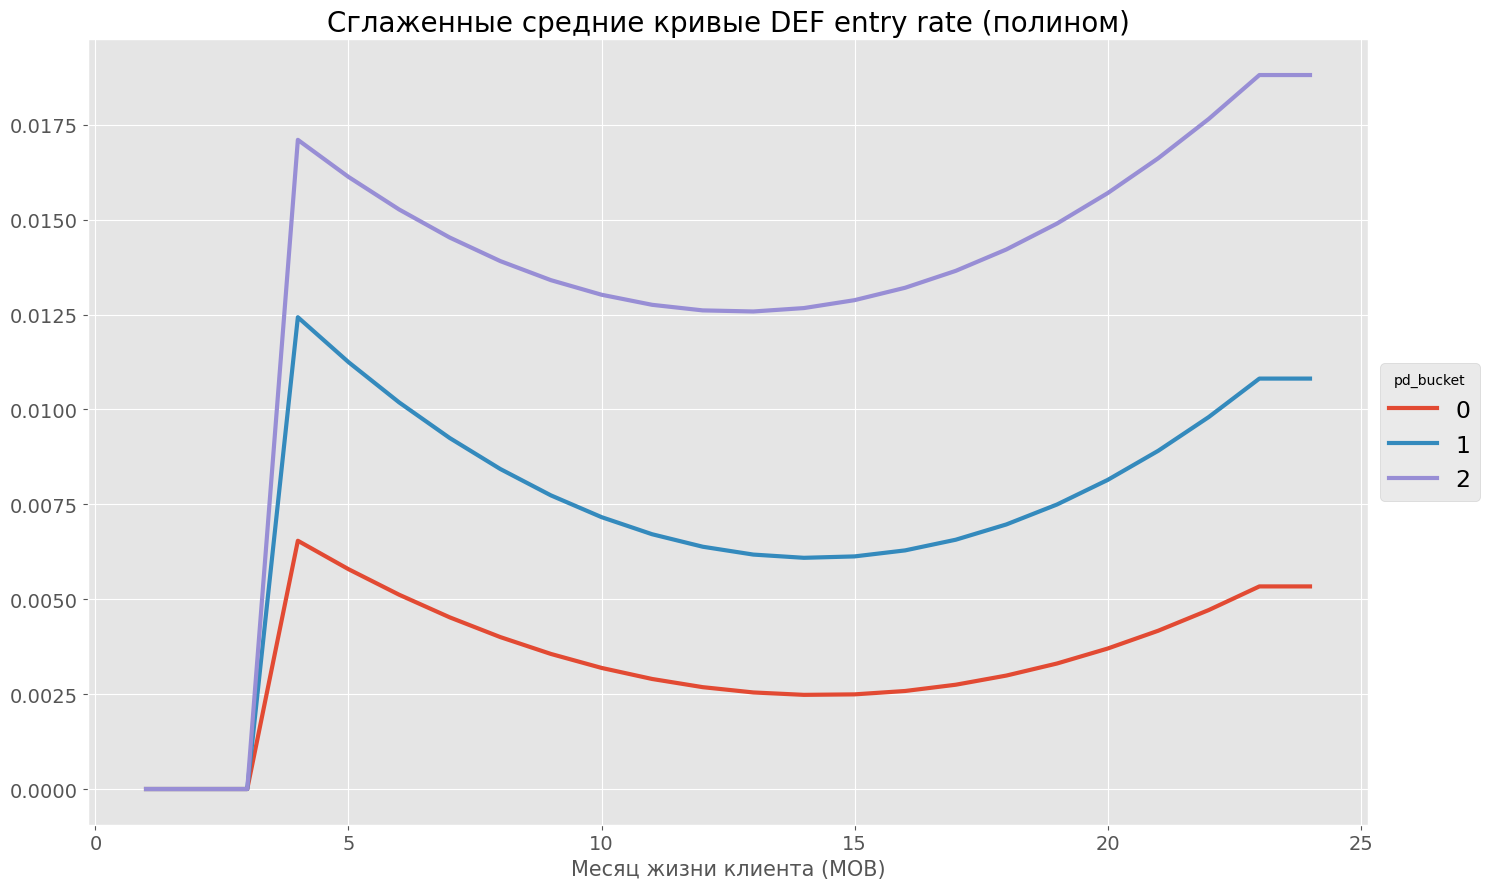

In [67]:
def approximation(
    res,
    start=4,
    finish=22,
    degree=2,
    group_col="pd_bucket",
    x_col="statement_num",
    y_col="fitted_feature",
):

    buckets = sorted(res["fitted_data"][group_col].dropna().unique())

    # средняя кривая по бакету и MOB
    curve_mean = (
        res["fitted_data"]
        .groupby([group_col, x_col])[y_col]
        .mean()
        .rename("Среднее")
    )
    mean_df = curve_mean.reset_index()

    df_smooth_result = pd.DataFrame()

    for bucket in buckets:
        df_temp = (
            mean_df.query(f"{group_col} == @bucket")
                   .set_index(x_col)
                   .sort_index()
        )

        df_smooth_result[str(bucket)] = polynom_approximation(
            df_temp, start=start, finish=finish, degree=degree
        )["Полином"]

    df_smooth_result.index.name = x_col
    return df_smooth_result

df_smooth_result = approximation(res, start=4, finish=22, degree=2)

df_smooth_result.plot(figsize=(15, 9), grid=True, lw=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17, title="pd_bucket")
plt.title("Сглаженные средние кривые DEF entry rate (полином)", size=20)
plt.xlabel("Месяц жизни клиента (MOB)", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил(-a) сглаживание? Почему?

Выбранная функция сглаживания - полиномиальная аппроксимация 2-й степени.

Сглаживание применялось не ко всем точкам, а только на интервале 4-22. Ранние месяцы (1-3) могут быть разреженными и нестабильными из-за стартовых эффектов и малого объёма наблюдений, а в районе 4 наблюдается системный пик, который важно не "размазывать" и не использовать как основной якорь для подгонки всей формы. На хвосте (> 22) объём наблюдений обычно снижается и растёт дисперсия, поэтому аппроксимация хвоста увеличивает риск переобучения и артефактных колебаний; по этой причине после finish кривая продолжается константой, что даёт стабильное поведение хвоста для расчётов NPV.

### Отрисуй сглаженные кривые по всем трем бакетам PD

In [70]:
# код здесь

# ДУБЛИРУЮ!

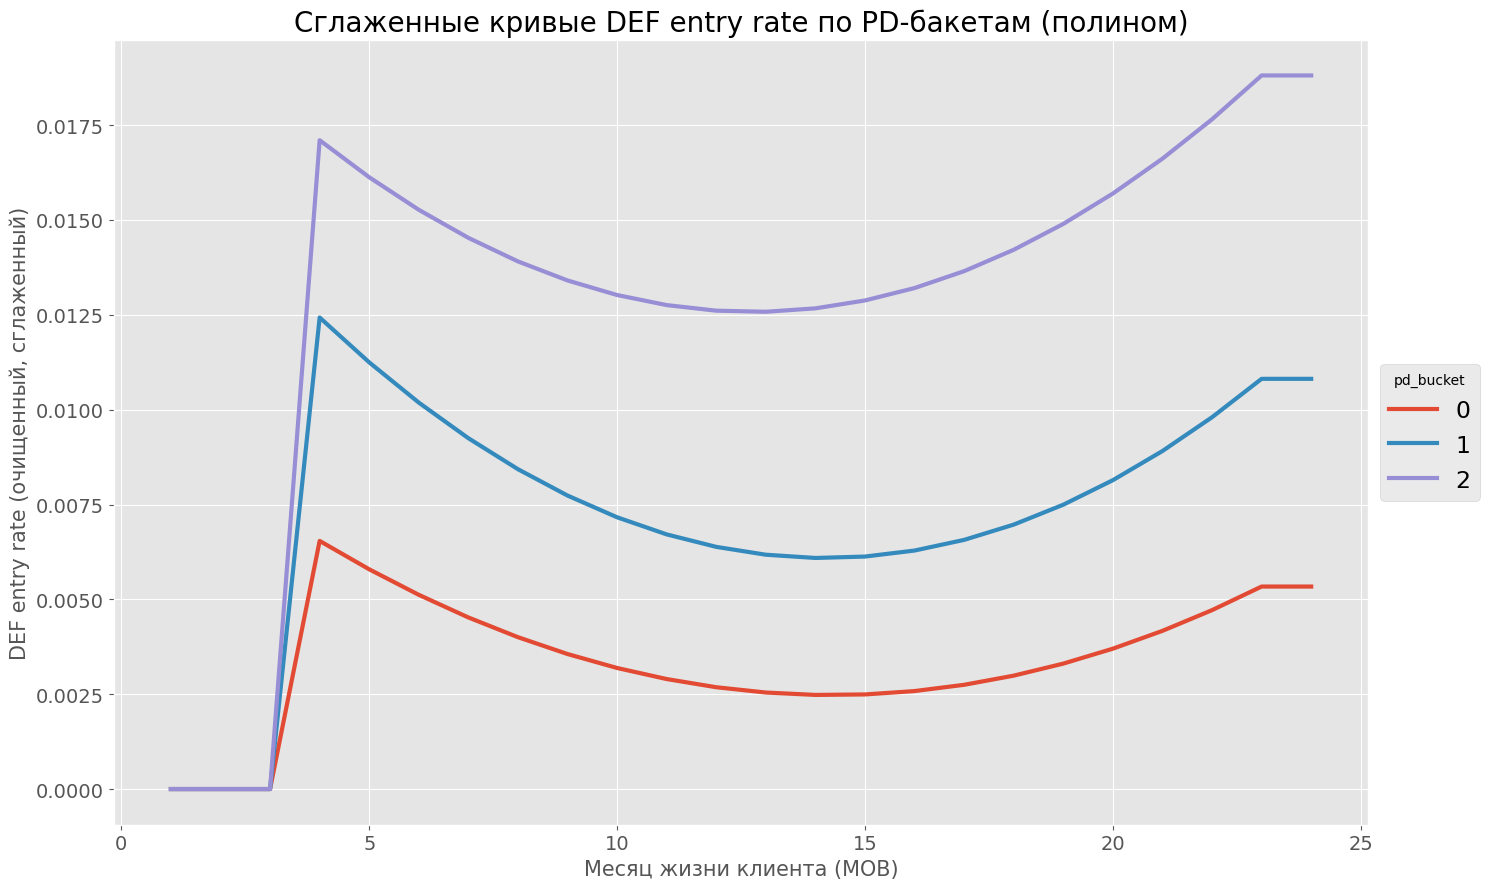

In [71]:
ax = df_smooth_result[["0", "1", "2"]].plot(figsize=(15, 9), grid=True, lw=3)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17, title="pd_bucket")
plt.title("Сглаженные кривые DEF entry rate по PD-бакетам (полином)", size=20)
plt.xlabel("Месяц жизни клиента (MOB)", size=15)
plt.ylabel("DEF entry rate (очищенный, сглаженный)", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

# Внедрение в NPV-модель

## Добавь в NPV-модель метод с расчетом DEF rate по твоей кривой

In [74]:
pd_q1, pd_q2 = df_scores["pd"].quantile([1/3, 2/3]).values
pd_edges = (pd_q1, pd_q2)

In [75]:
# Код NPV-модели с прошлого семинара

import numpy as np

class NPVModel:

    avg_missed_payments = 1.5
    recovery = 0.50
    dlq_penalty_amount = 500
    oper_costs = 100
    collection_costs = 600
    tax_rate = 0.20
    discounting_rate = 0.30
    eq_req = 0.125
    cost_of_funds = 0.16
    dlq_ratio = np.ones(101)*0.20
    dlq_ratio[0] = 0
    shift = 4
    clo_rate = 1 / (np.arange(shift, shift + 101) ** 2)
    acquisition_cost = 1000

    # ___________________________ НАЧАЛО КОРРЕКТИРОВКИ 1! ___________________________
    
    # ДОБАВЛЯЮ параметры страховки
    
    # Страховка стоит 0.5% от лимита, выплаты ежемесячно
    insurance_monthly_fee_rate = 0.005
    
    # Подключена у 40% клиентов в статусе CUR
    insurance_share_cur = 0.40
    
    #  и у 60% в статусе DLQ
    insurance_share_dlq = 0.60
    
    # Возможно наступление страхового случая с вероятностью 0.1% (в каждый месяц), 
    # при подключенной страховке мы должны возместить всю сумму текущей задолженности
    insurance_claim_prob = 0.001
    
    # ___________________________ КОНЕЦ КОРРЕКТИРОВКИ 1! ___________________________

    def __init__(self):
        pass

    def model_balance_calculations(self, amount, rate, term):
        '''
        Расчет модельных баланса, выплаченных процентов, регулярного платежа
        :param amount: Сумма кредита
        :param rate: Ставка
        :param term: Срок
        :return:
        balance : np.array(101) : остаток тела долга по кредиту на каждый месяц
        interest : np.array(101) : выплата по процентам каждый месяц
        regular_payment : float : размер регулярного платежа
        '''

        regular_payment = round(amount * (rate / 12) *\
                                (1 + (rate / 12)) / (1 - ((1 + rate / 12) ** (-term))))
        # График баланса и процентов
        balance = np.zeros(101)
        interest = np.zeros(101)
        balance[0] = amount

        for i in range(1, term + 1):
            int_payment = balance[i - 1] * rate / 12
            debt_payment = regular_payment - int_payment
            balance[i] = max(0, round(balance[i - 1] - debt_payment))
            interest[i] = int_payment
        return balance, interest, regular_payment

    def distribution_calc(self, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет распределения по статусам
        :param portfolio_distribution: график распределения по статусам
        :return:
        cur_dist : np.array(101) : доля клиентов в статусе CUR на каждый месяц
        dlq_dist : np.array(101) : доля клиентов в статусе DLQ на каждый месяц
        act_dist : np.array(101) : доля клиентов в статусе ACT на каждый месяц
        def_dist : np.array(101) : доля клиентов в статусе DEF на каждый месяц
        clo_dist : np.array(101) : доля клиентов в статусе CLO на каждый месяц
        '''
        
        cur_dist = portfolio_distribution['CUR']
        dlq_dist = portfolio_distribution['DLQ']
        act_dist = cur_dist + dlq_dist
        def_dist = portfolio_distribution['DEF'] 
        clo_dist = portfolio_distribution['CLO']

        return cur_dist, dlq_dist, act_dist, def_dist, clo_dist

    def cur_balance_calc(self, model_balance, cur_dist):
        '''
        Расчет модельного баланса в статусе CUR
        :param model_balance: плановый график баланса
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        principal_balance_cur : np.array(101) : principal balance в статусе CUR
        gross_balance_cur : np.array(101) : gross balance в статусе CUR
        '''
        principal_balance_cur = model_balance*cur_dist
        gross_balance_cur = model_balance*cur_dist
        return principal_balance_cur, gross_balance_cur

    def dlq_balance_calc(self, model_balance, regular_payment, dlq_dist):
        '''
        Расчет модельного баланса в статусе DLQ
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_dlq : np.array(101) : principal balance в статусе DLQ
        gross_balance_dlq : np.array(101) : gross balance в статусе DLQ
        '''
        principal_balance_dlq = np.append(model_balance[1:], model_balance[-1])*dlq_dist
        gross_balance_dlq = (model_balance + regular_payment*self.avg_missed_payments)*dlq_dist
        return principal_balance_dlq, gross_balance_dlq

    def act_balance_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq):
        '''
        Расчет модельного баланса в статусе ACT
        :param principal_balance_cur: principal balance в статусе CUR
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param gross_balance_cur: principal balance в статусе CUR
        :param gross_balance_dlq: principal balance в статусе DLQ
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_act : np.array(101) : principal balance в статусе ACT
        gross_balance_act : np.array(101) : gross balance в статусе ACT
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq
        gross_balance_act = gross_balance_cur + gross_balance_dlq
        return principal_balance_act, gross_balance_act

    def def_balance_calc(self, model_balance, regular_payment, def_dist):
        '''
        Расчет модельного баланса в статусе DEF
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        principal_balance_def : np.array(101) : principal balance в статусе DEF
        gross_balance_def : np.array(101) : gross balance в статусе DEF
        '''
        principal_balance_def = np.zeros(101)
        gross_balance_def = np.zeros(101)

        def_dist_change = def_dist[4:] - def_dist[3:-1]
        principal_balance_def[4:] = np.cumsum(model_balance[:-4] * def_dist_change)
        gross_balance_def[4:] = np.cumsum((model_balance[4:] + 4 * regular_payment) * def_dist_change)

        return principal_balance_def, gross_balance_def

    def profit_calc(self, principal_balance_act, principal_balance_def, term, rate, dlq_dist):
        '''

        :param principal_balance_act: principal balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param rate: тавка по кредиту
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        profit : np.array(101) : доход на каждый месяц
        '''
        interest_profit = principal_balance_act*rate/12
        penatly_profit = dlq_dist*self.dlq_penalty_amount

        new_def_balance = np.append(principal_balance_def[1:], 0) - principal_balance_def
        recovery_profit = new_def_balance*self.recovery

        profit = interest_profit + recovery_profit + penatly_profit
        profit[term+1:] = 0

        return profit

    def loss_calc(self, gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param act_dist: доля клиентов в статусе ACT на каждый месяц
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        loss : np.array(101) : лосс на каждый месяц
        '''
        oper_loss = np.append(act_dist[1:], 0)*self.oper_costs
        loan_loss =  principal_balance_def - np.append(0, principal_balance_def[:-1])
        collection_loss = (np.append(dlq_dist[1:], 0) + np.append(def_dist[1:], 0))*self.collection_costs

        prev_gross_balance_act = np.append(gross_balance_act[0], gross_balance_act[1:])
        cost_of_funds_loss = prev_gross_balance_act*(1 - self.eq_req)*self.cost_of_funds/12

        loss = loan_loss + cost_of_funds_loss + oper_loss + collection_loss
        loss[term+1:] = 0

        return loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss

    def assets_liabilities_calc(self, gross_balance_act):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :return:
        assets : np.array(101) : активы в проекте
        eq_req_curve : np.array(101) : активы, обеспеченные капиталом
        fund_req_curve : np.array(101) : активы, обеспеченные фондами
        '''

        # assets
        assets = gross_balance_act

        #liabilities
        eq_req_curve = assets*self.eq_req
        fund_req_curve = assets*(1 - self.eq_req)

        return assets, eq_req_curve, fund_req_curve

    def niat_calc(self, profit, loss):
        '''
        Расчет NIAT
        :param profit: суммарный доход на каждый месяц
        :param loss: суммарный лосс на каждый месяц
        :return:
        nibt : np.array(101) : прибыль до налогообложения
        niat : np.array(101) : прибыль после налогообложения
        tax : np.array(101) : налог в каждом месяце
        '''

        nibt = profit - loss
        tax = nibt*self.tax_rate
        niat = nibt - tax

        return nibt, niat, tax

    def cashflow_calc(self, principal_balance_act, principal_balance_def, amount, profit,
                      cost_of_funds_loss, oper_costs, collection_costs, tax, niat, eq_req_curve, fund_req_curve):
        '''
        Расчет денежных потоков
        :param principal_balance_act: principal balance в статусе DEF
        :param principal_balance_def: principal balance в статусе DEF
        :param amount: срок кредита
        :param profit: доход на каждый месяц
        :param cost_of_funds_loss: лоссы на фондирование
        :param oper_costs: операционные расходы
        :param collection_costs: расходы на коллекшн
        :param tax: налог в каждом месяце
        :param niat: доход после налогообложения
        :param eq_req_curve: активы, обеспеченные капиталом
        :param fund_req_curve: активы, обеспеченные фондами
        :return:
        cf_to_client : np.array(101) : денежный поток к клиенту
        cf_to_shareholders : np.array(101) : денежный поток к акционерам
        cf_to_debtholders : np.array(101) : денежный поток к фондам
        cf_to_cost_and_tax : np.array(101) : денежный поток на косты и налоги
        '''
        # client
        delta_principal_balance_act = (np.append(0, principal_balance_act[:100]) - principal_balance_act)
        delta_principal_balance_def = (np.append(0, principal_balance_def[:100]) - principal_balance_def)
        repayments = delta_principal_balance_act - delta_principal_balance_def + profit
        cf_to_client = np.append(amount, -repayments[1:])

        # debtoholder
        fund_req_ch = fund_req_curve - np.append(fund_req_curve[0], fund_req_curve[:-1])
        fund_req_change = np.append(fund_req_curve[0], fund_req_ch[1:])
        cf_to_debtholders = cost_of_funds_loss - fund_req_change

        # shareholders
        eq_req_ch = eq_req_curve - np.append(eq_req_curve[0], eq_req_curve[:-1])
        cf_to_shareholders = niat - np.append(eq_req_curve[0], eq_req_ch[1:])

        # cost and tax
        cf_to_cost_and_tax = oper_costs + collection_costs + tax

        return cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax
        
    def npv_calc(self, amount, rate, term, pd=None):
        '''
        Расчет NPV с внутренним вычислением portfolio_distribution
        :param amount: сумма кредита
        :param rate: ставка по кредиту
        :param term: срок кредита
        :param def_rate: доля дефолтных клиентов к концу срока
        :param clo_rate: доля закрытых клиентов к концу срока
        :param pd: вероятность дефолта к 12-ому месяцу
        :param pa: вероятность полного досрочного погашения к 6-ому месяцу
        :return: npv: чистая приведенная стоимость кредита
        '''

        # Считаем балансы
        model_balance, interest, regular_payment = self.model_balance_calculations(amount, rate, term)
        
        # Рассчитываем распределение по статусам
        cur_dist = np.zeros(101)
        dlq_dist = np.zeros(101)
        def_dist = np.zeros(101)
        clo_dist = np.zeros(101)
        act_dist = np.zeros(101)
        
        # В начале все клиенты в статусе CUR
        act_dist[0] = 1
        cur_dist[0] = 1
        
        self.def_rate = self.def_rate_calc(pd)

        # А мне кажется, или мы тут неправильно считаем clo_dist и def_dist? Вроде, по смыслу, 
        # они должны быть накопленными величинами (в прошлой домашке так было), а тут получается, 
        # что это прибавка относительно прошлого месяца?

        # о не кажется
        # надо значение в предыдущий месяц прибавлять

        for i in range(1, term + 1):
            clo_dist[i] = self.clo_rate[i] * act_dist[i - 1]
            def_dist[i] = self.def_rate[i] * act_dist[i - 1]
            act_dist[i] = act_dist[i - 1] - clo_dist[i] - def_dist[i]
            dlq_dist[i] = self.dlq_ratio[i] * act_dist[i]
            cur_dist[i] = act_dist[i] - dlq_dist[i]
            

        portfolio_distribution = {
            'CUR': cur_dist,
            'DLQ': dlq_dist,
            'DEF': def_dist,
            'CLO': clo_dist
        }

        # Считаем распределение
        cur_dist, dlq_dist, act_dist, def_dist, clo_dist = self.distribution_calc(portfolio_distribution)

        # Считаем балансы
        principal_balance_cur, gross_balance_cur = self.cur_balance_calc(model_balance, cur_dist)
        principal_balance_dlq, gross_balance_dlq = self.dlq_balance_calc(model_balance, regular_payment, dlq_dist)
        principal_balance_act, gross_balance_act = self.act_balance_calc(principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq)
        principal_balance_def, gross_balance_def = self.def_balance_calc(model_balance, regular_payment, def_dist)

        # Считаем профиты
        profit = self.profit_calc(principal_balance_act, principal_balance_def, term, rate, dlq_dist)
        loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss = self.loss_calc(
            gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist
        )
        # nibt, niat, tax = self.niat_calc(profit, loss)

        # ___________________________ НАЧАЛО КОРРЕКТИРОВКИ 2! ___________________________
        
        # Страховая премия (доход) - 0.5% от лимита ежемесячно, подключена у 40% CUR и 60% DLQ
        insurance_premium = amount * self.insurance_monthly_fee_rate * (
            cur_dist * self.insurance_share_cur + dlq_dist * self.insurance_share_dlq
        )

        # Страховой случай (ожидаемый расход) - p = 0.1% в месяц, выплата = текущая задолженность
        insurance_claim_loss = self.insurance_claim_prob * (
            gross_balance_cur * self.insurance_share_cur + gross_balance_dlq * self.insurance_share_dlq
        )

        # Обрезаем после срока кред.
        insurance_premium[term + 1:] = 0
        insurance_claim_loss[term + 1:] = 0

        # Вносим в P&L
        profit = profit + insurance_premium
        loss = loss + insurance_claim_loss

        # ___________________________ КОНЕЦ КОРРЕКТИРОВКИ 2! ___________________________

        # Пересчитываем NIAT ПОСЛЕ страховки
        nibt, niat, tax = self.niat_calc(profit, loss)

        # Считаем активы и денежные потоки
        assets, eq_req_curve, fund_req_curve = self.assets_liabilities_calc(gross_balance_act)
        cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax =\
            self.cashflow_calc(
                principal_balance_act, principal_balance_def, amount, profit,
                cost_of_funds_loss, oper_loss, collection_loss,
                tax, niat, eq_req_curve, fund_req_curve
            )

        # Считаем NPV
        disc_curve = np.array([1 / ((1 + self.discounting_rate) ** (i / 12.)) for i in range(101)])
        pv = np.round(np.sum(disc_curve * cf_to_shareholders)).astype(int)
        npv = pv - self.acquisition_cost

        return npv

    def set_def_curves(self, df_smooth_result, pd_edges):
        """
        df_smooth_result: DataFrame
            index = statement_num (MOB), columns = '0','1','2' (pd_bucket),
            values = сглаженный DEF entry rate (hazard) по MOB.
        pd_edges: tuple(float, float)
            границы бакетов по PD: (q1, q2), где
            bucket 0: pd <= q1
            bucket 1: q1 < pd <= q2
            bucket 2: pd > q2
        """
        self.def_curves_df = df_smooth_result.copy()
        self.pd_edges = pd_edges

        return self
    
    def def_rate_calc(self, pd_value=None):
        # Реализуй тут метод для расчета def_rate
        # Метод должен возвращать def_rate

        # добавлю импорт тут!
        import pandas as pd
    
        # проверки наличия кривых
        if not hasattr(self, "def_curves_df"):
            raise AttributeError("Не заданы кривые DEF: вызови model.set_def_curves(df_smooth_result, pd_edges)")
        if not hasattr(self, "pd_edges"):
            raise AttributeError("Не заданы границы бакетов PD: вызови model.set_def_curves(df_smooth_result, pd_edges)")
    
        # выбираем бакет по pd
        if pd_value is None or (isinstance(pd_value, float) and np.isnan(pd_value)):
            # нейтральный бакет по умолчанию
            bucket = 1
        else:
            q1, q2 = self.pd_edges
            if pd_value <= q1:
                bucket = 0
            elif pd_value <= q2:
                bucket = 1
            else:
                bucket = 2
    
        col = str(bucket)
        if col not in self.def_curves_df.columns:
            raise KeyError(f"В def_curves_df нет колонки '{col}'. Ожидаются '0','1','2'.")
    
        # собираем кривую длиной 101
        def_rate = np.zeros(101, dtype=float)
    
        # хотим значения для MOB=1..100
        mob_index = np.arange(1, 101)
    
        s = self.def_curves_df[col].copy()
    
        # гарантируем числовой индекс MOB
        s.index = pd.to_numeric(s.index, errors="coerce")
        s = s.dropna()
        s = s.sort_index()
    
        # forward fill
        s_full = s.reindex(mob_index).ffill()
    
        # если вдруг первые MOB отсутствуют, заполним нулями
        s_full = s_full.fillna(0.0)
    
        # в массив: def_rate[i] соответствует месяцу i
        def_rate[1:] = s_full.values
    
        def_rate = np.clip(def_rate, 0.0, 1.0)
    
        return def_rate

## Посчитай NPV по кредиту с параметрами

- Срок кредита 2 года
- Годовая процентная ставка 21%
- Сумма кредита 1 млн
- Страховка подключена

In [77]:
model = NPVModel()

# возьму так
pd_edges = (0.05, 0.15)

model.set_def_curves(df_smooth_result, pd_edges)

npv = model.npv_calc(
    amount=1_000_000,
    rate=0.21,
    term=24,
    pd=0.10
)

print("NPV кредита:", npv)

NPV кредита: 33446


## Построй график зависимости NPV от скора, которым ты побил(-а) DEF rate

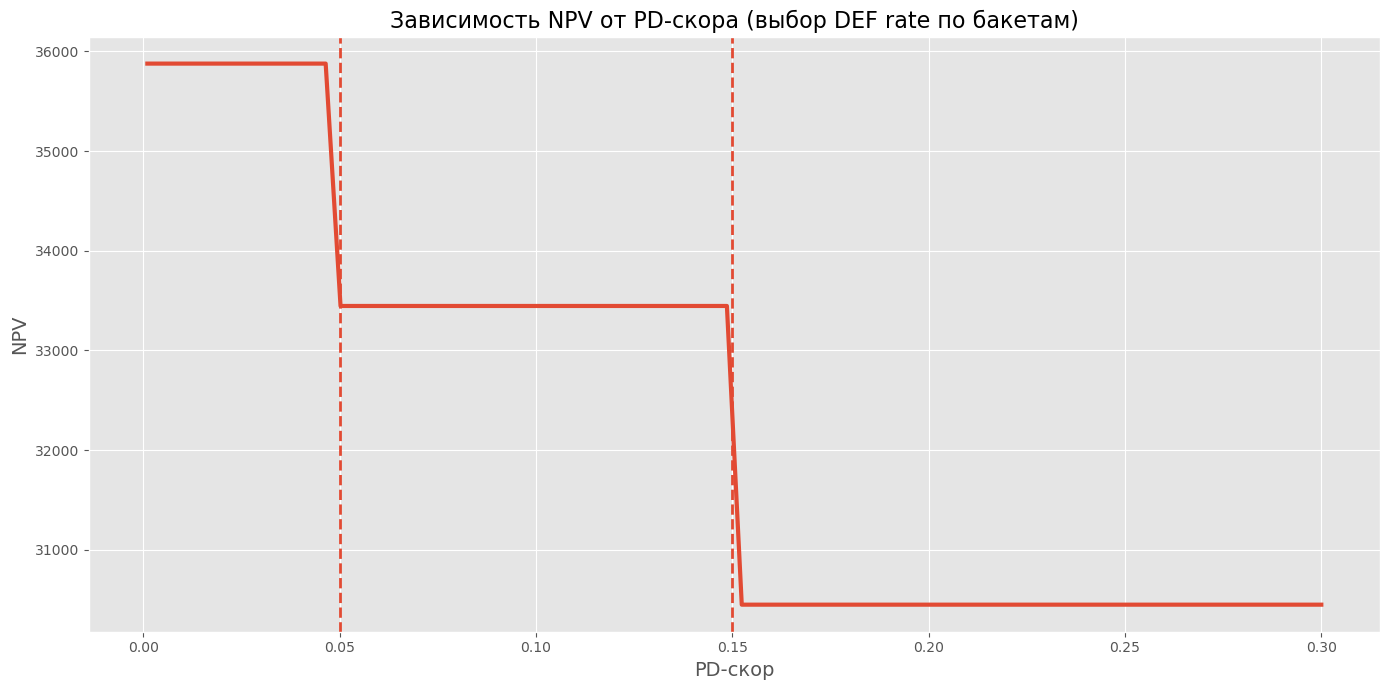

In [126]:
# границы бакетов
pd_edges = (0.05, 0.15)
model.set_def_curves(df_smooth_result, pd_edges)

# Сетка значений "скора" (pd), по которому выбирается бакет DEF rate

# тут можно растянуть при желании
pd_grid = np.linspace(0.001, 0.30, 80)

# Считаем NPV для каждого pd
npv_list = []
bucket_list = []

for pd_value in pd_grid:
    q1, q2 = pd_edges
    if pd_value <= q1:
        bucket = 0
    elif pd_value <= q2:
        bucket = 1
    else:
        bucket = 2
    bucket_list.append(bucket)

    npv = model.npv_calc(
        amount=1_000_000,
        rate=0.21,
        term=24,
        pd=float(pd_value)
    )
    npv_list.append(npv)

res_curve = pd.DataFrame({
    "pd_score": pd_grid,
    "npv": npv_list,
    "pd_bucket": bucket_list
})

# График NPV от pd
plt.figure(figsize=(14, 7))
plt.plot(res_curve["pd_score"], res_curve["npv"], lw=3)

# вертикальные линии границ бакетов
plt.axvline(pd_edges[0], linestyle="--", lw=2)
plt.axvline(pd_edges[1], linestyle="--", lw=2)

plt.grid(True)
plt.title("Зависимость NPV от PD-скора (выбор DEF rate по бакетам)", fontsize=16)
plt.xlabel("PD-скор", fontsize=14)
plt.ylabel("NPV", fontsize=14)
plt.tight_layout()
plt.show()